# Imports

In [1]:
import numpy as np
import pickle
import os
import re
import pandas as pd
from tqdm import tqdm
import glob
import networkx as nx

import sys
sys.path.append("../../scripts") # TODO: make this part of pythonpath?

import matplotlib.pyplot as plt

from scripts.run_bubblewrap import BubblewrapRun

In [2]:
all_inline = True

# Individual analysis

## Individial file discovery/loading

In [309]:
files = glob.glob("*pickle")
files.sort()
files[-10:]

['bubblewrap_run_2023-05-09-16-16-26.pickle',
 'bubblewrap_run_2023-05-09-16-16-32.pickle',
 'bubblewrap_run_2023-05-09-16-16-39.pickle',
 'bubblewrap_run_2023-05-09-16-16-47.pickle',
 'bubblewrap_run_2023-05-09-16-16-53.pickle',
 'bubblewrap_run_2023-05-09-16-16-59.pickle',
 'bubblewrap_run_2023-05-09-16-17-06.pickle',
 'bubblewrap_run_2023-05-09-16-17-11.pickle',
 'bubblewrap_run_2023-05-09-16-17-17.pickle',
 'bubblewrap_run_2023-05-09-16-17-23.pickle']

In [310]:
file = 'bubblewrap_run_2023-05-10-12-47-22.pickle'
file

'bubblewrap_run_2023-05-10-12-47-22.pickle'

In [311]:
with open(file, "rb") as fhan:
    br = pickle.load(fhan)
    if br.bw_parameters and "seed" not in br.bw_parameters:
        br.bw_parameters["seed"] = 42

In [312]:
for key, value in br.bw_parameters.items():
    print(f"{key}: {value}")
print(f"input file: {br.file}")
print(f"savefile: {br.outfile}")
print(f"# of dead nodes: {len(br.dead_nodes)}")
print(f"# of steps: {br.entropy_list.shape[0]}")

num: 200
lam: 0.001
nu: 0.001
eps: 1e-05
step: 0.08
M: 30
B_thresh: -10
batch: False
batch_size: 1
go_fast: False
lookahead_steps: [1, 2, 3, 4, 5, 8, 10, 16, 32, 64, 128]
seed: 42
save_A: False
input file: ./generated/datasets/shuffled_neuropixel_reduced_10d.npy
savefile: generated/bubblewrap_runs/bubblewrap_run_2023-05-10-12-47-22.pickle
# of dead nodes: 0
# of steps: 74330


## Smoothed Entropy/Prop plot

In [313]:
def one_sided_ewma(data, com):
    return pd.DataFrame(data=dict(data=data)).ewm(com).mean()["data"]

def two_sided_ewma(data, half_width=75):
    kernel = np.linspace(0,10,half_width)
    kernel = np.exp(kernel)
    kernel = np.hstack((kernel, np.flip(kernel)))
    kernel = kernel/kernel.sum()
    return np.convolve(data, kernel, 'valid')

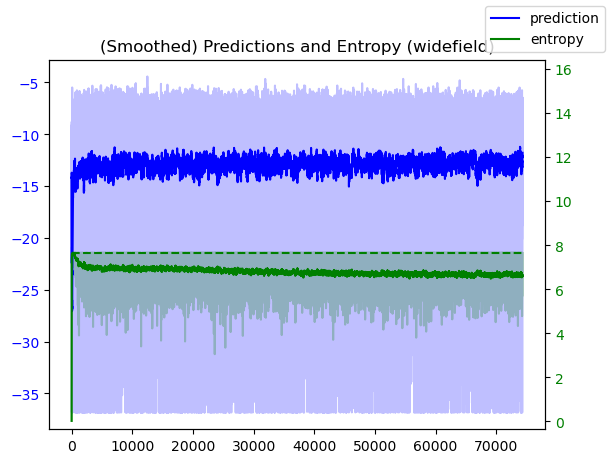

In [316]:
# shows smoothed predictions and entropy
if not all_inline:
    %matplotlib qt

smooting_scale = 50

predictions = br.pred_list[:,0]
smoothed_predictions = one_sided_ewma(predictions,smooting_scale)

fig, ax1 = plt.subplots()
ax1.plot(predictions, alpha=0.25, color='blue')
ax1.plot(smoothed_predictions, color='blue', label = "prediction")
ax1.tick_params(axis='y',labelcolor='blue')
ax1.set_title(f"(Smoothed) Predictions and Entropy ({dataset})")


entropy = br.entropy_list[:,0]
smoothed_entropy = one_sided_ewma(entropy, smooting_scale)
ax2 = ax1.twinx()
ax2.plot(entropy, color='green', alpha=0.25)
ax2.plot(smoothed_entropy, color='green', label="entropy")
max_entropy = np.log2(br.bw_parameters["num"])
ax2.plot([0, entropy.shape[0]], [max_entropy,]*2, 'g--')
ax2.tick_params(axis='y',labelcolor='green')
ymin, ymax = ax2.get_ylim()
ax2.set_ylim((ymin, 2*(ymax-ymin) + ymin))

fig.legend()

## $A$ graph analysis

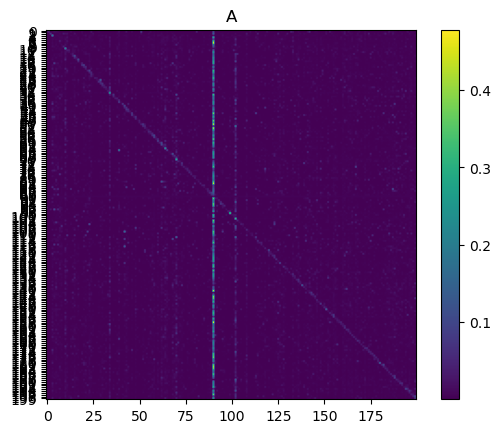

In [317]:
%matplotlib inline

fig, ax = plt.subplots()
im = ax.imshow(br.A)
ax.set_title("A")

live_nodes = [x for x in np.arange(br.bw_parameters["num"]) if x not in br.dead_nodes]
ax.set_yticks(live_nodes);
fig.colorbar(im)

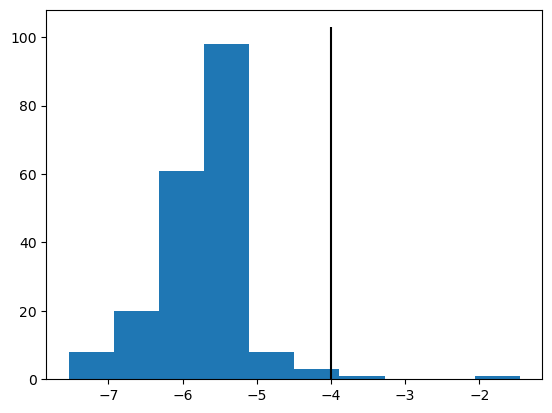

In [318]:
node_cutoff = -4

alphas = br.alpha_list[-br.alpha_list.shape[0]//4:,:]

fig, ax = plt.subplots()
counts, _, _ = ax.hist(np.log(alphas.mean(axis=0)))

ax.vlines([node_cutoff], ymin=0, ymax=counts.max()*1.05, color='k')

In [319]:
A = br.A
mask = alphas.mean(axis=0) > np.exp(node_cutoff)
A_less_nodes = A[mask]
A_less_nodes = A_less_nodes[:,mask]

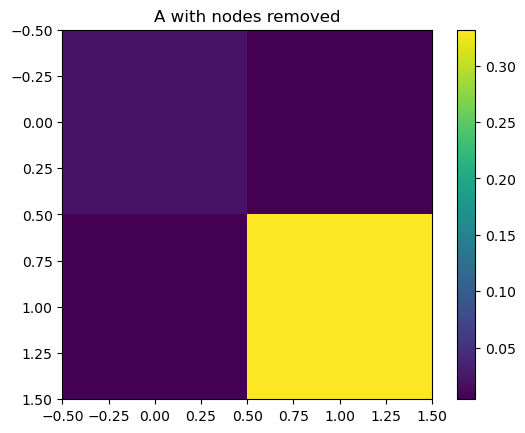

In [320]:
fig, ax = plt.subplots()
im = ax.imshow(A_less_nodes)
ax.set_title("A with nodes removed")

fig.colorbar(im)

In [22]:
A_no_diagonals = np.array(A_less_nodes)
A_no_diagonals[np.diag_indices(A_no_diagonals.shape[0])] = 0

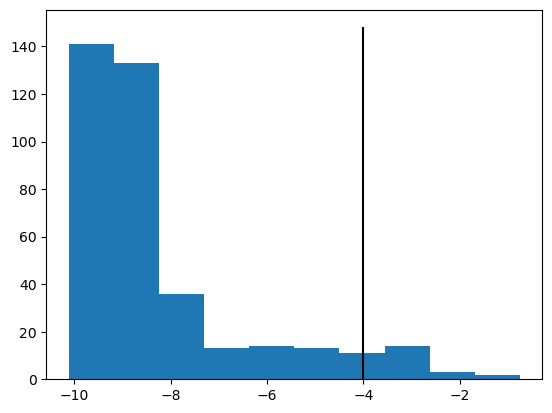

In [25]:
edge_cutoff = -4

fig, ax = plt.subplots()
counts, _, _ = ax.hist(np.log(A_no_diagonals[A_no_diagonals > 1e-10]))

ax.vlines([edge_cutoff], ymin=0, ymax=counts.max()*1.05, color='k')

In [26]:
A_less_edges = np.array(A_no_diagonals)
A_less_edges[A_less_edges < np.exp(edge_cutoff)] = 0

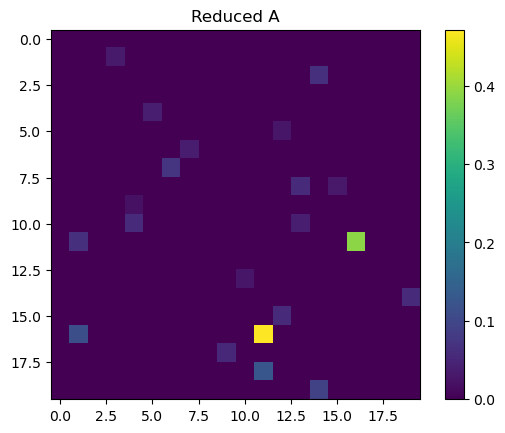

In [27]:
%matplotlib inline

fig, ax = plt.subplots()
im = ax.imshow(A_less_edges)
ax.set_title("Reduced A")
fig.colorbar(im)

In [28]:
A_few_edges_few_nodes =  np.array(A_less_edges)
mask = np.logical_or(A_less_edges.std(axis=0)>0, A_less_edges.std(axis=1)>0)
A_few_edges_few_nodes = A_few_edges_few_nodes[mask]
A_few_edges_few_nodes = A_few_edges_few_nodes[:,mask]

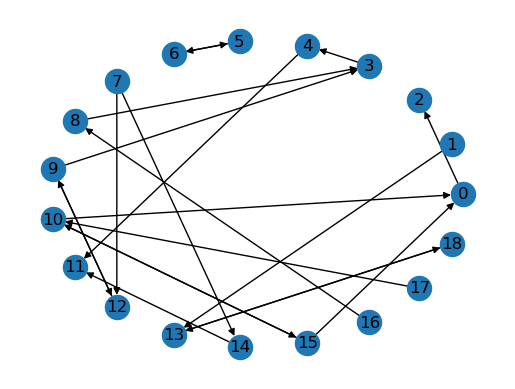

In [29]:
G = nx.from_numpy_array(A_few_edges_few_nodes, create_using = nx.DiGraph())

fig, ax = plt.subplots()
nx.draw_circular(G, with_labels=True)
# nx.draw_kamada_kawai(G, with_labels=True)
# nx.draw_planar(G, with_labels=True)
# nx.draw_random(G, with_labels=True)
# nx.draw_spectral(G, with_labels=True)
# nx.draw_spring(G, with_labels=True)
# nx.draw_shell(G, with_labels=True)

# Comparing new and old forcasting metrics

## Files

### Datasets definition

In [304]:
datasets = pd.DataFrame(columns=["old_way_file", "new_way_file", "shuffled_old_way_file", "shuffled_new_way_file", "has_A", "has_states"])

In [305]:
datasets.loc['clock fast'] = \
    dict(
        old_way_file = 'bubblewrap_run_2023-04-27-11-48-30.pickle',
        new_way_file = 'bubblewrap_run_2023-04-27-11-49-13.pickle',
        shuffled_new_way_file = 'bubblewrap_run_2023-05-02-17-40-32.pickle',
        has_A = True,
        has_states = True,
    )

datasets.loc['clock slow'] = \
    dict(
        old_way_file = 'bubblewrap_run_2023-04-27-11-50-01.pickle',
        new_way_file = 'bubblewrap_run_2023-04-27-11-50-47.pickle',
        shuffled_new_way_file = 'bubblewrap_run_2023-05-02-17-39-30.pickle',
        has_A = True,
        has_states = True,
    )

datasets.loc['clock halfspeed'] = \
    dict(
        old_way_file = "bubblewrap_run_2023-04-27-11-39-10.pickle",
        new_way_file = "bubblewrap_run_2023-04-27-11-39-52.pickle",
        shuffled_old_way_file = "bubblewrap_run_2023-04-27-11-40-41.pickle",
        shuffled_new_way_file = "bubblewrap_run_2023-04-27-11-41-28.pickle",
        has_A = True,
        has_states = True,
    )


datasets.loc['monkey reach'] = \
    dict(
        old_way_file = "bubblewrap_run_2023-04-27-11-41-57.pickle",
        new_way_file = "bubblewrap_run_2023-04-27-11-42-12.pickle",
        shuffled_new_way_file = 'bubblewrap_run_2023-05-02-17-41-05.pickle',
        has_A = True,
        has_states = False,
    )

datasets.loc['neuropixel short'] = \
    dict(
        old_way_file = 'bubblewrap_run_2023-04-27-12-22-38.pickle',
        new_way_file = 'bubblewrap_run_2023-04-27-12-22-44.pickle',
        has_A = True,
        has_states = False,
    )

datasets.loc['mouse short'] = \
    dict(
        old_way_file = 'bubblewrap_run_2023-04-27-12-23-43.pickle',
        new_way_file = 'bubblewrap_run_2023-04-27-12-24-36.pickle',
        has_A = True,
        has_states = False,
    )


datasets.loc['widefield short'] = \
    dict(
        old_way_file = 'bubblewrap_run_2023-04-27-12-25-31.pickle',
        new_way_file = 'bubblewrap_run_2023-04-27-12-26-25.pickle',
        has_A = True,
        has_states = False,
    )

datasets.loc['neuropixel'] = \
    dict(
        old_way_file = 'bubblewrap_run_2023-04-27-14-55-21.pickle',
        new_way_file = 'bubblewrap_run_2023-04-27-15-01-37.pickle',
        shuffled_new_way_file = 'bubblewrap_run_2023-05-02-17-49-17.pickle',
        has_A = False,
        has_states = False,
    )


datasets.loc['mouse 200'] = \
    dict(
        old_way_file = 'bubblewrap_run_2023-04-27-15-09-55.pickle',
        new_way_file = 'bubblewrap_run_2023-04-27-15-18-06.pickle',
        has_A = False,
        has_states = False,
    )


datasets.loc['widefield'] = \
    dict(
        old_way_file = 'bubblewrap_run_2023-04-27-15-25-37.pickle',
        new_way_file = 'bubblewrap_run_2023-04-27-15-32-54.pickle',
        shuffled_new_way_file = 'bubblewrap_run_2023-05-02-17-58-25.pickle',
        has_A = False,
        has_states = False,
    )


datasets.loc['mouse 1k'] = \
    dict(
        old_way_file = 'bubblewrap_run_2023-05-01-17-20-24.pickle',
        new_way_file = 'bubblewrap_run_2023-05-01-18-24-38.pickle',
        has_A = False,
        has_states = False,
    )

datasets.loc['mouse short'] = \
    dict(
        old_way_file = 'bubblewrap_run_2023-05-02-17-22-19.pickle',
        new_way_file = 'bubblewrap_run_2023-05-03-09-27-01.pickle',
        has_A = False,
        has_states = False,

    )

datasets.loc['mouse'] = \
    dict(
        old_way_file = 'bubblewrap_run_2023-05-03-14-56-18.pickle',
        new_way_file ='bubblewrap_run_2023-05-03-15-16-01.pickle',
        shuffled_new_way_file = 'bubblewrap_run_2023-05-03-16-14-39.pickle',
        has_A = False,
        has_states = False,
    )



In [306]:
def assert_brs_match(brs):
    for i in range(len(brs)-1):
        assert brs[i].bw_parameters == brs[i+1].bw_parameters

for dataset in datasets.index:
    br_s = []
    for column in [column for column in datasets if "file" in column]:
        if not pd.isna(datasets.loc[dataset, column]):
            with open(datasets.loc[dataset, column], "rb") as fhan:
                br = pickle.load(fhan)
            br_s.append(br)
    assert_brs_match(br_s)

### Dataset loading

In [322]:
dataset = 'monkey reach'

with open(datasets.loc[dataset].new_way_file, "rb") as fhan:
    new_way_br = pickle.load(fhan)

with open(datasets.loc[dataset].old_way_file, "rb") as fhan:
    old_way_br = pickle.load(fhan)

shuffled_br = None
if not pd.isna(datasets.loc[dataset].shuffled_new_way_file):
    with open(datasets.loc[dataset].shuffled_new_way_file, "rb") as fhan:
        shuffled_br = pickle.load(fhan)


    
states = None
if datasets.loc[dataset].has_states:
    states = np.load("../datasets/"+new_way_br.file.split("/")[-1])["x"]

In [323]:
for key, value in new_way_br.bw_parameters.items():
    print(f"{key}: {value}")
print(f"input file: {new_way_br.file}")
print(f"savefile: {new_way_br.outfile}")
print(f"# of dead nodes: {len(new_way_br.dead_nodes)}")
print(f"# of steps: {new_way_br.entropy_list.shape[0]}")

num: 200
lam: 0.001
nu: 0.001
eps: 0.001
step: 0.08
M: 30
B_thresh: -10
batch: False
batch_size: 1
go_fast: False
lookahead_steps: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 25, 32, 35, 40, 50, 64, 80, 100, 128, 256, 512]
seed: 42
save_A: True
input file: ./generated/jpca_reduced.npy
savefile: generated/bubblewrap_runs/bubblewrap_run_2023-04-27-11-42-12.pickle
# of dead nodes: 166
# of steps: 2268


In [23]:
assert new_way_br.bw_parameters.items() == old_way_br.bw_parameters.items()
assert np.all(new_way_br.entropy_list == old_way_br.entropy_list)
assert np.all((new_way_br.pred_list == old_way_br.pred_list)[:,0])
assert new_way_br.bw_parameters["lookahead_steps"] == old_way_br.bw_parameters["lookahead_steps"]
assert np.all(new_way_br.A == old_way_br.A)
print((new_way_br.pred_list == old_way_br.pred_list)[:,1:].mean())

0.0


## A Inspection

### A History (optional)

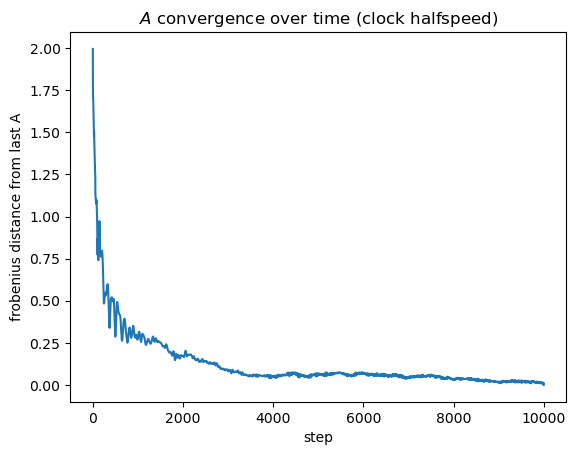

In [24]:
%matplotlib inline
if datasets.loc[dataset].has_A:
    plt.plot(np.linalg.norm(new_way_br.A_list - new_way_br.A_list[-1], axis=(1,2)))
    plt.xlabel("step")
    plt.ylabel("frobenius distance from last A")
    plt.title(f"$A$ convergence over time ({dataset})");

In [26]:
if datasets.loc[dataset].has_A:
    AA = new_way_br.A_list
    A_differences = np.zeros((AA.shape[0], AA.shape[0]))
    for i in tqdm(range(AA.shape[0])):
        for j in range(AA.shape[0]):
            A_differences[i,j] = np.linalg.norm(AA[i] - AA[j])
            A_differences[j,i] = A_differences[i,j]


100%|█████████████████████████████████████| 10000/10000 [02:50<00:00, 58.75it/s]


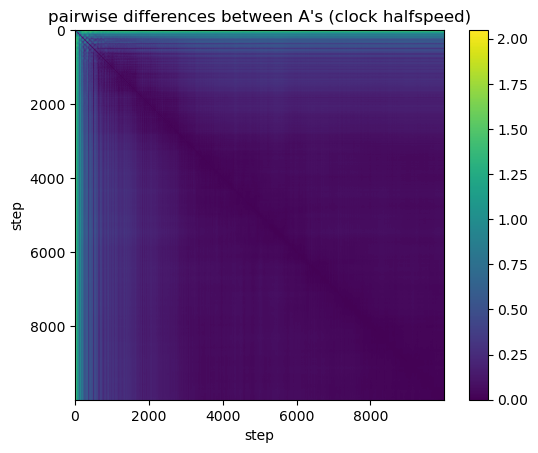

In [27]:
if datasets.loc[dataset].has_A:

    plt.imshow((A_differences))
    plt.title(f"pairwise differences between A's ({dataset})")
    plt.xlabel("step")
    plt.ylabel("step")

    plt.colorbar();

In [29]:
if datasets.loc[dataset].has_A:
    
    AA = new_way_br.A_list
    AAH = np.array([np.power(a,100) for a in AA])

    Ah_differences = np.zeros((AA.shape[0], AA.shape[0]))
    for i in tqdm(range(AA.shape[0])):
        for j in range(AA.shape[0]):
            Ah_differences[i,j] = np.linalg.norm(AAH[i] - AAH[j])
            Ah_differences[j,i] = Ah_differences[i,j]


100%|█████████████████████████████████████| 10000/10000 [02:55<00:00, 56.93it/s]


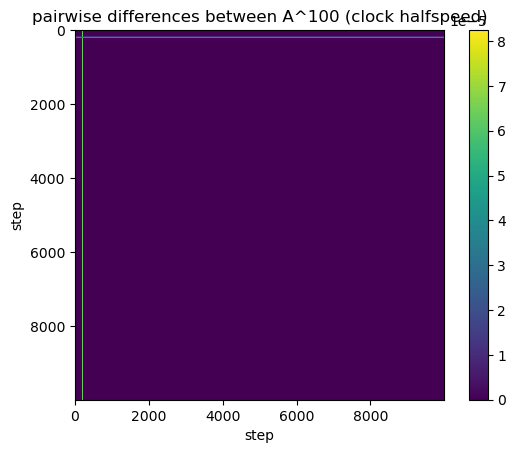

In [30]:
if datasets.loc[dataset].has_A:

    %matplotlib inline
    plt.imshow((Ah_differences))
    plt.title(f"pairwise differences between A^100 ({dataset})")
    plt.xlabel("step")
    plt.ylabel("step")

    plt.colorbar();

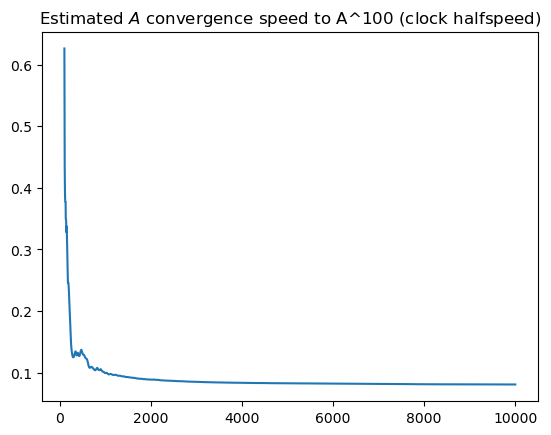

In [31]:
if datasets.loc[dataset].has_A:
    %matplotlib inline
    def get_slope(a):
        power = 20
        a_final = np.linalg.matrix_power(a, 100)
        current = a
        distances = []
        for _ in range(power+1):
            distances.append(np.linalg.norm(current - a_final))
            current = current @ a
        d = np.diff(np.log(distances))


        return d[10:].mean()

    plt.figure()
    slopes = []
    end = AA.shape[0]
    start = 100
    for i in range(start,end):
        slopes.append(get_slope(AA[i]))
    slopes = np.array(slopes)
    plt.plot(np.arange(start,end),-slopes)
    plt.title(f"Estimated $A$ convergence speed to A^100 ({dataset})");

### Current A

Text(0, 0.5, 'eigenvalue')

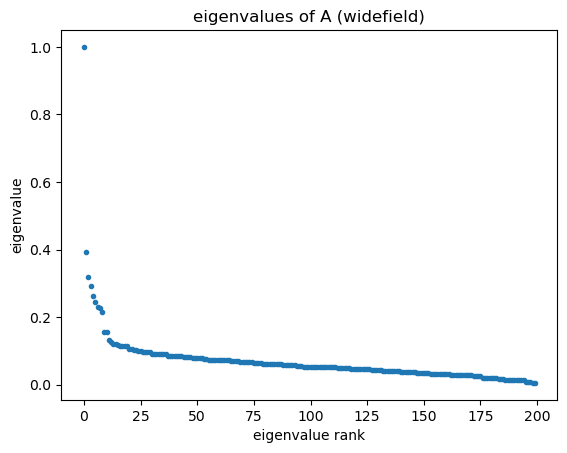

In [321]:
# s = np.sort(np.abs(np.linalg.eigvals(old_way_br.A)))[::-1]
s = np.sort(np.abs(np.linalg.eigvals(br.A)))[::-1]
plt.plot(s,'.')
plt.title(f"eigenvalues of A ({dataset})")
plt.xlabel("eigenvalue rank")
plt.ylabel("eigenvalue")

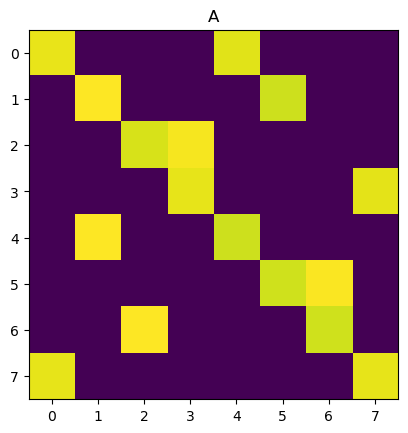

In [33]:
if not all_inline:
    %matplotlib qt
    
fig, ax = plt.subplots()
ax.imshow(new_way_br.A)
ax.set_title("A")

live_nodes = [x for x in np.arange(new_way_br.bw_parameters["num"]) if x not in new_way_br.dead_nodes]
ax.set_yticks(live_nodes);


## Prediction History

### On average

#### Average performance by steps_ahead

In [34]:
# calculates for the next cell

T = new_way_br.pred_list.shape[0]
new_way_means = []
old_way_means = []
shuffled_means = []

new_way_stds = []
old_way_stds = []
shuffled_stds = []
for i, step in enumerate(new_way_br.bw_parameters["lookahead_steps"]):
    first_nonzero = np.nonzero(np.isnan(new_way_br.pred_list[:,i]))[0]
    if len(first_nonzero):
        local_T = first_nonzero[0]
    else:
        local_T = T
    new_way_means.append(np.mean(new_way_br.pred_list[-local_T//2:local_T,i]))
    new_way_stds.append(np.std(new_way_br.pred_list[-local_T//2:local_T,i], ddof=1))
    # print(f"new way {step:>2} step(s) ahead mean: {new_way_means[-1]}")

for i, step in enumerate(old_way_br.bw_parameters["lookahead_steps"]):
    old_way_means.append(np.mean(old_way_br.pred_list[-T//2:,i]))
    old_way_stds.append(np.std(old_way_br.pred_list[-T//2:,i], ddof=1))
    # print(f"old way {step:>2} step(s) ahead mean: {old_way_means[-1]}")

if shuffled_br is not None:
    for i, step in enumerate(shuffled_br.bw_parameters["lookahead_steps"]):
        first_nonzero = np.nonzero(np.isnan(shuffled_br.pred_list[:,i]))[0]
        if len(first_nonzero):
            local_T = first_nonzero[0]
        else:
            local_T = T
        shuffled_means.append(np.mean(shuffled_br.pred_list[-local_T//2:local_T,i]))
        shuffled_stds.append(np.std(shuffled_br.pred_list[-local_T//2:local_T,i], ddof=1))
        # print(f"new way {step:>2} step(s) ahead mean: {new_way_means[-1]}")


new_way_means = np.array(new_way_means)
old_way_means = np.array(old_way_means)

new_way_stds = np.array(new_way_stds)
old_way_stds = np.array(old_way_stds)

if shuffled_br is not None:
    shuffled_stds = np.array(shuffled_stds)
    shuffled_means = np.array(shuffled_means)

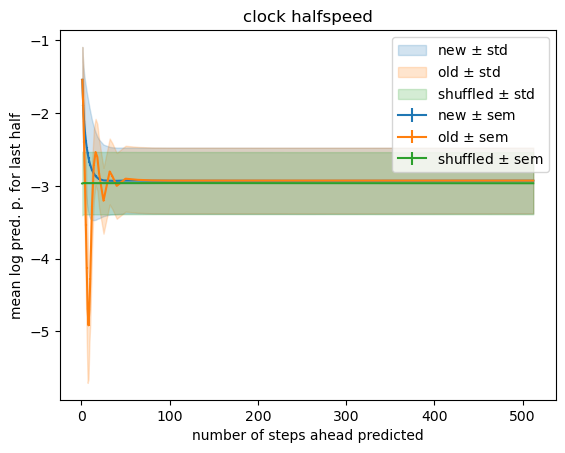

In [35]:
# plots averages across step numbers
if not all_inline:
    %matplotlib qt
    
plt.figure()
plt.errorbar(new_way_br.bw_parameters["lookahead_steps"], new_way_means, new_way_stds/np.sqrt(T/2))
plt.errorbar(new_way_br.bw_parameters["lookahead_steps"], old_way_means, old_way_stds/np.sqrt(T/2),)
if shuffled_br is not None:
    plt.errorbar(new_way_br.bw_parameters["lookahead_steps"], shuffled_means, shuffled_stds/np.sqrt(T/2),)
plt.fill_between(new_way_br.bw_parameters["lookahead_steps"], new_way_means - new_way_stds,new_way_means+ new_way_stds, color="C0", alpha=0.2)
plt.fill_between(new_way_br.bw_parameters["lookahead_steps"], old_way_means - old_way_stds,old_way_means+ old_way_stds, color="C1", alpha=0.2)
if shuffled_br is not None:
    plt.fill_between(new_way_br.bw_parameters["lookahead_steps"], shuffled_means - shuffled_stds,shuffled_means+ shuffled_stds, color="C2", alpha=0.2)
    plt.legend(["new $\pm$ std", "old $\pm$ std","shuffled $\pm$ std","new $\pm$ sem", "old $\pm$ sem", "shuffled $\pm$ sem"])
else:
    plt.legend(["new $\pm$ std", "old $\pm$ std", "new $\pm$ sem", "old $\pm$ sem"])
plt.ylabel("mean log pred. p. for last half")
plt.xlabel("number of steps ahead predicted")
plt.title(f"{dataset}");

### Over Time

#### Tune smoothing factor

In [105]:
if not all_inline:
    %matplotlib qt


data = old_way_br.pred_list[:,0]
smoothed_data1 = one_sided_ewma(data,40)

plt.plot(data, alpha=.5)
plt.plot(smoothed_data1);

half_width = 100
smoothed_data2 = two_sided_ewma(data,half_width)
plt.plot(np.arange(smoothed_data2.size) + half_width, smoothed_data2);

plt.legend(["1-step predictions", "one-sided smoothed", "two-sided smoothed"]);

#### Smoothed Predictions and alpha

In [121]:
# shows smoothed predictions over time

if not all_inline:
    %matplotlib qt
    
show_states_instead_of_alpha = True

smoothing_scale = 40
br = shuffled_br

fig, axs = plt.subplots(2,1, sharex=True)
steps = [1,2,3]
for si, step in enumerate(steps):
    i = br.bw_parameters["lookahead_steps"].index(step)
    old_pred = br.pred_list[:,i]
    new_pred = br.pred_list[:,i]
    # plt.plot(pred)


    smoothed_old_pred = one_sided_ewma(old_pred, smoothing_scale)
    smoothed_new_pred = one_sided_ewma(new_pred, smoothing_scale)
    half_width = 0 # NOTE: set this if you use the two-sided ewma function
    
    axs[0].plot(np.arange(smoothed_old_pred.size) + half_width, smoothed_old_pred, color=f'C{si}', linestyle='dashed')
    x_correction = (step-1)*1
    axs[0].plot(np.arange(smoothed_new_pred.size) + half_width + x_correction,smoothed_new_pred, color=f'C{si}',linestyle='solid')

legend = []
for step in steps:
    legend.append(f"old {step} step")
    legend.append(f"new {step} step")
axs[0].legend(legend)
axs[0].set_title(f"{dataset} smoothed prediction")
axs[0].set_xlabel("timestep")
axs[0].set_ylabel("log pred. prob.");



if states is not None and show_states_instead_of_alpha:
    axs[1].plot(states,'.')
else:
    alpha = br.alpha_list.T
    state_means = alpha.mean(axis=1)
    # alpha = alpha[state_means > np.quantile(state_means, .75),:]
    alpha = alpha[np.argsort(-alpha.mean(axis=1)) - (alpha.shape[0]//2),:]
    axs[1].imshow((alpha), aspect="auto", interpolation="nearest")
# axs[0].set_xlim([500, 1000])

#### Smoothed predictions and entropy

In [123]:
# shows smoothed predictions and entropy
if not all_inline:
    %matplotlib qt

    
br = new_way_br

smooting_scale = 50

predictions = br.pred_list[:,0]
smoothed_predictions = one_sided_ewma(predictions,smooting_scale)

fig, ax1 = plt.subplots()
ax1.plot(predictions, alpha=0.25, color='blue')
ax1.plot(smoothed_predictions, color='blue', label = "prediction")
ax1.tick_params(axis='y',labelcolor='blue')
ax1.set_title(f"(Smoothed) Predictions and Entropy ({dataset})")


entropy = br.entropy_list[:,0]
smoothed_entropy = one_sided_ewma(entropy, smooting_scale)
ax2 = ax1.twinx()
ax2.plot(entropy, color='green', alpha=0.25)
ax2.plot(smoothed_entropy, color='green', label="entropy")
max_entropy = np.log2(br.bw_parameters["num"])
ax2.plot([0, entropy.shape[0]], [max_entropy,]*2, 'g--')
ax2.tick_params(axis='y',labelcolor='green')
ymin, ymax = ax2.get_ylim()
ax2.set_ylim((ymin, 2*(ymax-ymin) + ymin))

fig.legend()

## State-prediction link

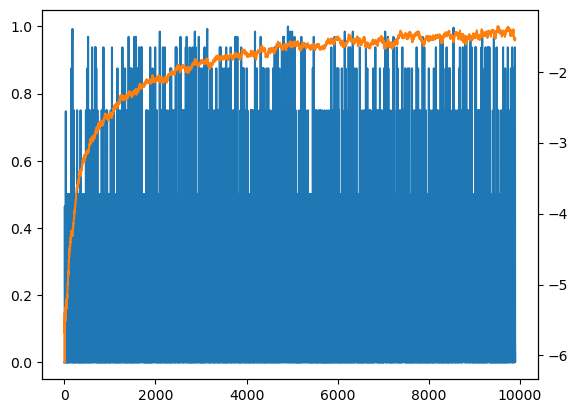

In [39]:
if not all_inline:
    %matplotlib qt

fig, ax1 = plt.subplots()
    
alpha = alpha = new_way_br.alpha_list.T

early_clip = 100

biggest_state = alpha[np.argmax(alpha.mean(axis=1)),:]
smoothed_biggest_state = one_sided_ewma(biggest_state[early_clip:], 1)
ax1.plot(smoothed_biggest_state, alpha=1)


ax2 = ax1.twinx()
new_pred = new_way_br.pred_list[:,0]
smoothed_new_pred = one_sided_ewma(new_pred[early_clip:], 50)
ax2.plot(smoothed_new_pred, color="C1", alpha=1)

In [40]:
np.corrcoef(smoothed_biggest_state[smoothed_biggest_state.shape[0]//2:], smoothed_new_pred[smoothed_new_pred.shape[0]//2:])[0,1]

0.04361624575610169

## Dataset

### Loading the data

In [58]:
def get_dataset_from_file(file):
    f =  file.split("/")[-1]
    f = "neuropixel_reduced_10d.npy" if f == "neuropixel_reduced.npz" else f
    data = np.load("../datasets/" +f)
    data = data.T if "npy" in f else data["y"][0]
    return data

In [59]:
data = get_dataset_from_file(new_way_br.file)

### Pairwise distances

In [60]:
def ac1(data, shift=1):
    x = data - data.mean(axis=0)
    T = x.shape[0]

    # precision = np.linalg.inv(np.cov(x.T))
    precision = np.eye(x.shape[1])
    total = 0
    differences = x[0:T-shift] - x[shift:T]
    for i in range(differences.shape[0]):
        total += np.sqrt(differences[i] @ precision @ differences[i])
    total /= (T-shift)
    return total

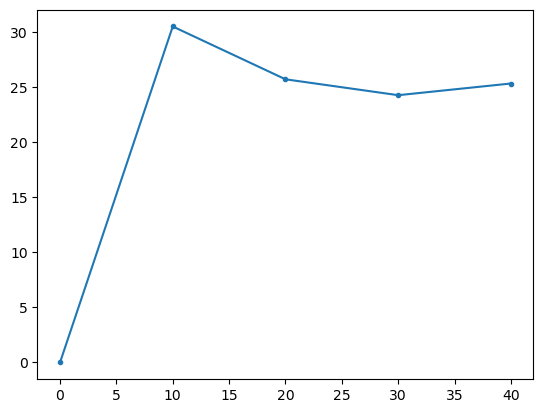

In [86]:
if not all_inline:
    %matplotlib qt
def mean_distance(data, shift=1):
    x = data - data.mean(axis=0)
    T = x.shape[0]
    
    differences = x[0:T-shift] - x[shift:T]
    distances = np.linalg.norm(differences,axis=1)
    
    return distances.mean()

x = np.arange(0,50,10)
plt.plot(x,[mean_distance(data,shift) for shift in x], '.-')

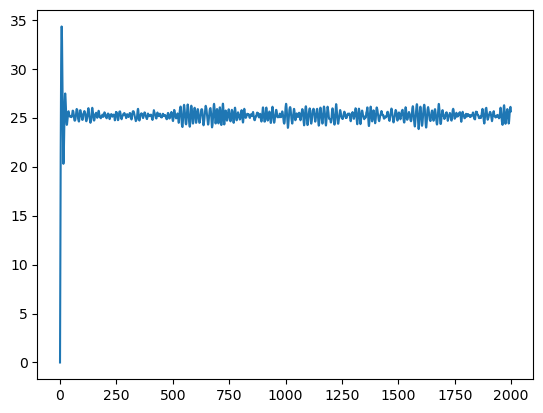

In [87]:
x = np.arange(2000)
plt.plot(x,[ac1(data, shift) for shift in x])

### Autocorrelation

In [69]:
def autocorr(data, shift=1):
    x = data - data.mean(axis=0)
    T = x.shape[0]
    
    behind = x[0:T-shift,:] 
    ahead = x[shift:T,:]
    total = np.zeros((x.shape[1], x.shape[1]))
    for i in range(T-shift):
        total = total + behind[i,:,None] @ ahead[None,i,:]
    total = total/ (T-shift) #ddof ?
    

    behind_std = 1/np.std(behind, axis=0, ddof=1)[:,None]
    ahead_std = 1/np.std(ahead, axis=0, ddof=1)[None,:]
    total = behind_std * total * ahead_std
    return total

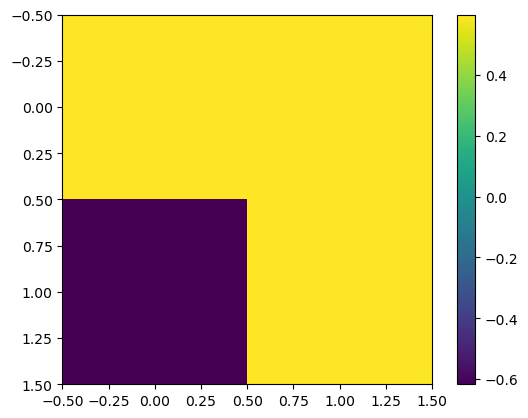

In [70]:
fig, ax = plt.subplots()
c = autocorr(data,2)
im = ax.imshow(c)
fig.colorbar(im);

200.54767250266804

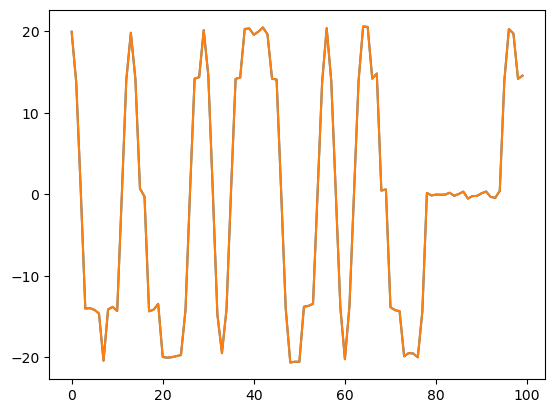

In [71]:
x = data - data.mean(axis=0)
shift = 0
T = 100
behind = x[0:T-shift,0]
ahead = x[shift:T,0]
plt.plot(behind)
plt.plot(ahead)
(behind * ahead).sum() / (T-shift-1)

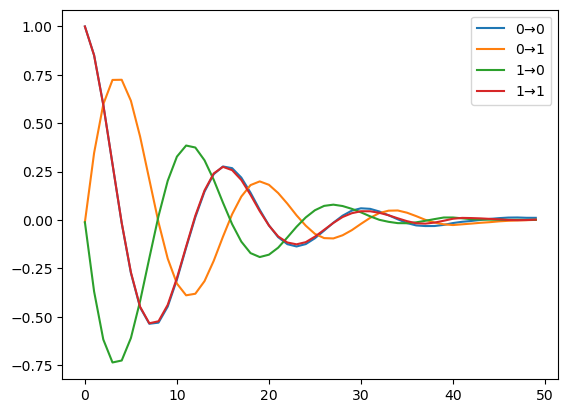

In [72]:
x = np.arange(50)
covs = []
for i in x:
    covs.append(autocorr(data,i))
covs = np.array(covs)

for c, (i,j) in enumerate(np.ndindex(covs.shape[1:])):
    trace = covs[:,i,j]
    if False:
        trace = trace - trace.min()
        trace = trace / trace.max()
        trace = trace + c
    plt.plot(trace, label=f"{i}$\\to${j}")
plt.legend()

# All-dataset comparisons

In [130]:
to_look_at_with_shuffles = np.array([['clock fast', 'clock slow', 'clock halfspeed', 'clock halfspeed shuffled'],['neuropixel','mouse', 'monkey reach', 'widefield', ],['neuropixel shuffled','mouse shuffled', 'monkey reach shuffled', 'widefield shuffled', ],])
to_look_at = np.array([['clock fast', 'clock slow', 'clock halfspeed', 'clock halfspeed shuffled'],['neuropixel','mouse', 'monkey reach', 'widefield', ],])

In [74]:
to_look_at_with_shuffles.shape

(3, 4)

In [75]:
def plot_for_datasets(to_look_at, plot_function):
    fig, axes = plt.subplots(ncols=to_look_at.shape[1], nrows=to_look_at.shape[0], layout='tight')
    if len(axes.shape) == 1:
        axes = axes[None,:]

    for i, j in np.ndindex(to_look_at.shape):
        if to_look_at[i,j] is None:
            continue
        if "shuffle" not in to_look_at[i,j]:
            with open(datasets.loc[to_look_at[i,j]].new_way_file, "rb") as fhan:
                br = pickle.load(fhan)
        else:
            dataset = " ".join(to_look_at[i,j].split(" ")[:-1])
            with open(datasets.loc[dataset].shuffled_new_way_file, "rb") as fhan:
                br = pickle.load(fhan)
        plot_function(br, axes[i,j], to_look_at[i,j])



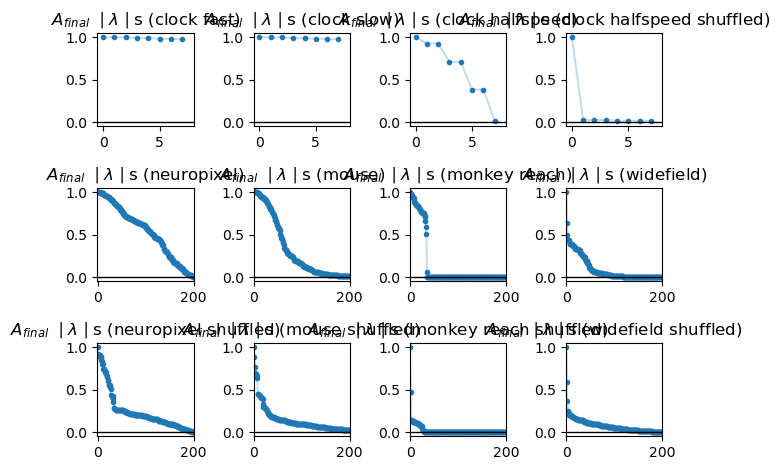

In [76]:
def plot_eigs(br, ax, name):
        e = np.abs(np.linalg.eigvals(br.A))
        ax.plot(np.sort(e)[::-1], '.')
        ax.plot(np.sort(e)[::-1], color="C0", alpha=0.25)
        ax.set_title("$A_{final}$ $\mid \\lambda \mid$s"+ f" ({name})")
        ax.set_ylim([-0.05,1.05])
        xlim = [-0.5,min(200, e.size)]
        ax.set_xlim(xlim)
        ax.hlines(0, *xlim, 'k', linewidth=1)
        
plot_for_datasets(to_look_at_with_shuffles, plot_eigs)

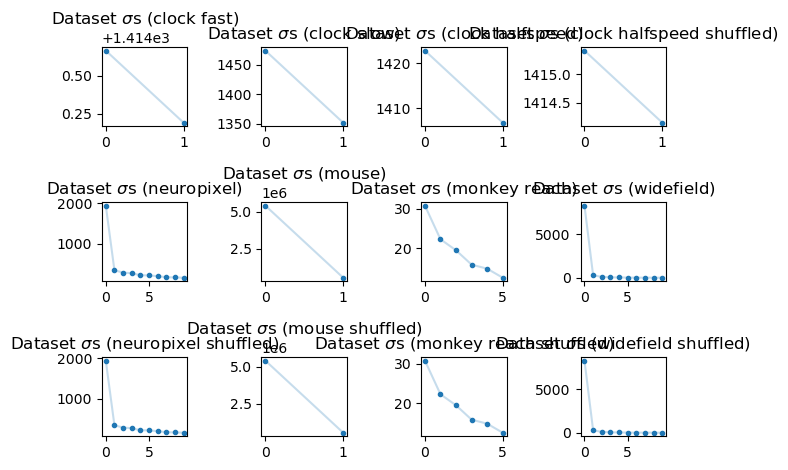

In [77]:
def plot_sings(br, ax, name):
    data = get_dataset_from_file(br.file)
    _,s,_ = np.linalg.svd(data, full_matrices=False)
    ax.plot(np.sort(s)[::-1], '.')
    ax.plot(np.sort(s)[::-1], color="C0", alpha=0.25)
    ax.set_title("Dataset $\\sigma$s"+ f" ({name})")
        
plot_for_datasets(to_look_at_with_shuffles, plot_sings)

In [200]:
if not all_inline:
    %matplotlib qt
def plot_step_distances(br, ax, name):
    data = get_dataset_from_file(br.file)
    x = np.arange(100)
    distances = [mean_distance(data, shift) for shift in x]
    ax.plot(x, distances, '.')
    ax.plot(x, distances, color="C0", alpha=0.25)
    ax.set_title("Distance by steps "+ f" ({name})")
        
plot_for_datasets(to_look_at_with_shuffles, plot_step_distances)

In [202]:
if not all_inline:
    %matplotlib qt
def plot_step_distances(br, ax, name):
    data = get_dataset_from_file(br.file)
    x = np.arange(50)
    covs = []
    for i in x:
        covs.append(autocorr(data,i))
    covs = np.array(covs)

    for c, (i,j) in enumerate(np.ndindex(covs.shape[1:])):
        trace = covs[:,i,j]
        if False:
            trace = trace - trace.min()
            trace = trace / trace.max()
            trace = trace + c
        ax.plot(trace, label=f"{i}$\\to${j}")
    ax.set_title("Autocorrelation "+ f" ({name})")
        
plot_for_datasets(to_look_at_with_shuffles, plot_step_distances)

In [201]:
if not all_inline:
    %matplotlib qt
def figure_5(br, ax, name):
    smooting_scale = 100

    predictions = br.pred_list[:,0]
    smoothed_predictions = one_sided_ewma(predictions,smooting_scale)

    ax.plot(predictions, alpha=0.25, color='blue')
    ax.plot(smoothed_predictions, color='blue', label = "prediction")
    ax.tick_params(axis='y',labelcolor='blue')
    ax.set_title(f"Pred. & Ent. ({name})")


    entropy = br.entropy_list[:,0]
    smoothed_entropy = one_sided_ewma(entropy, smooting_scale)
    ax2 = ax.twinx()
    ax2.plot(entropy, color='green', alpha=0.25)
    ax2.plot(smoothed_entropy, color='green', label="entropy")
    max_entropy = np.log2(br.bw_parameters["num"])
    ax2.plot([0, entropy.shape[0]], [max_entropy,]*2, 'g--')
    ax2.tick_params(axis='y',labelcolor='green')
    ymin, ymax = ax2.get_ylim()
    ax2.set_ylim((ymin, 2*(ymax-ymin) + ymin))
        
plot_for_datasets(to_look_at, figure_5)

# Figuring out figure 5

In [426]:
files = glob.glob("*pickle")
files.sort()
files = files[-20:]
files

['bubblewrap_run_2023-05-10-16-08-01.pickle',
 'bubblewrap_run_2023-05-10-16-08-07.pickle',
 'bubblewrap_run_2023-05-10-16-08-13.pickle',
 'bubblewrap_run_2023-05-10-16-08-19.pickle',
 'bubblewrap_run_2023-05-10-16-08-25.pickle',
 'bubblewrap_run_2023-05-10-16-08-31.pickle',
 'bubblewrap_run_2023-05-10-16-08-37.pickle',
 'bubblewrap_run_2023-05-10-16-08-45.pickle',
 'bubblewrap_run_2023-05-10-16-08-50.pickle',
 'bubblewrap_run_2023-05-10-16-08-57.pickle',
 'bubblewrap_run_2023-05-10-16-09-03.pickle',
 'bubblewrap_run_2023-05-10-16-09-10.pickle',
 'bubblewrap_run_2023-05-10-16-09-17.pickle',
 'bubblewrap_run_2023-05-10-16-09-22.pickle',
 'bubblewrap_run_2023-05-10-16-09-29.pickle',
 'bubblewrap_run_2023-05-10-16-09-35.pickle',
 'bubblewrap_run_2023-05-10-16-09-42.pickle',
 'bubblewrap_run_2023-05-10-16-09-49.pickle',
 'bubblewrap_run_2023-05-10-16-09-55.pickle',
 'bubblewrap_run_2023-05-10-16-10-02.pickle']

seed: [42, 0]


map

In [433]:
def plot_figure_5(brs):
    ps = [br.bw_parameters for br in brs]
    keys = set([leaf for tree in ps for leaf in tree.keys()])
    keep_keys = []
    for key in keys:
        values = [d[key] for d in ps]
        if not all([values[0] == v for v in values]):
            keep_keys.append(key)
    to_print = []
    for key in keep_keys:
        to_print.append(f"{key}: {[p[key] for p in ps]}")
    
    for p in to_print:
        print(p)
    
    fig, ax = plt.subplots(figsize=(5,5))

    smooting_scale = 100
    
    for idx, br in enumerate(brs):
        
        predictions = br.pred_list[br.bw_parameters["M"]+1:,0]
        smoothed_predictions = one_sided_ewma(predictions,smooting_scale)

        ax.plot(predictions, alpha=0.25, color='blue')
        c = 'black' if idx ==0 else 'blue'
        ax.plot(smoothed_predictions, color=c, label = br.outfile.split("/")[-1].split(".")[0].split("_")[-1])
        ax.tick_params(axis='y',labelcolor='blue')



        entropy = br.entropy_list[br.bw_parameters["M"]+1:,0]
        smoothed_entropy = one_sided_ewma(entropy, smooting_scale)
        ax2 = ax.twinx()
        ax2.plot(entropy, color='green', alpha=0.25)
        c = 'black' if idx ==0 else 'green'
        ax2.plot(smoothed_entropy, color=c)
        max_entropy = np.log2(br.bw_parameters["num"])
        ax2.plot([0, entropy.shape[0]], [max_entropy,]*2, 'g--')
        ax2.tick_params(axis='y',labelcolor='green')
        ymin, ymax = ax2.get_ylim()
        ax2.set_ylim([0,20])
        ax.set_ylim([-40,15])
        
        print(f"{br.pred_list[br.pred_list.shape[0]//2:,0].mean()-3.046}")
    ax.set_title(" ".join(to_print))
    fig.legend(loc="lower right")
        

    

step: [0.9, 0.2, 0.2]
eps: [0.001, 0.0, 0.001]


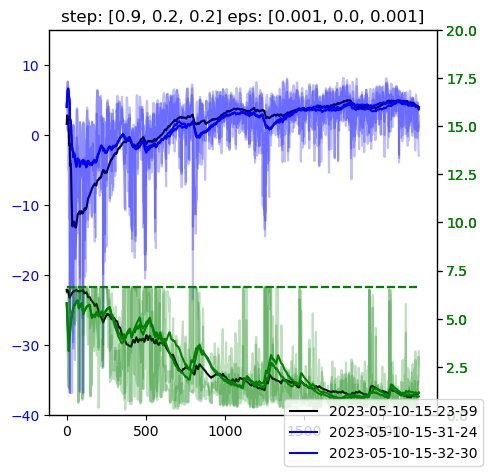

In [350]:
%matplotlib inline
files = [
 # 'bubblewrap_run_2023-05-05-15-56-43.pickle',
 # 'bubblewrap_run_2023-05-05-15-56-50.pickle',
 # 'bubblewrap_run_2023-05-08-09-27-41.pickle',
 # 'bubblewrap_run_2023-05-08-09-36-03.pickle',
 # 'bubblewrap_run_2023-05-08-09-37-32.pickle', ### old way
 # 'bubblewrap_run_2023-05-08-09-39-30.pickle',
    # 'bubblewrap_run_2023-05-08-09-56-38.pickle',
    # 'bubblewrap_run_2023-05-08-09-58-44.pickle',
    # 'bubblewrap_run_2023-05-08-09-59-36.pickle',
    # 'bubblewrap_run_2023-05-08-10-00-47.pickle',
    # 'bubblewrap_run_2023-05-08-10-01-30.pickle',
     # 'bubblewrap_run_2023-05-08-10-06-16.pickle'
    # 'bubblewrap_run_2023-05-08-10-07-21.pickle',
    # 'bubblewrap_run_2023-05-09-09-43-46.pickle',
    # 'bubblewrap_run_2023-05-09-09-44-46.pickle',
    # 'bubblewrap_run_2023-05-09-10-01-32.pickle',
    # 'bubblewrap_run_2023-05-09-10-02-37.pickle',
    # 'bubblewrap_run_2023-05-09-10-03-49.pickle', ###
    # 'bubblewrap_run_2023-05-09-10-05-04.pickle', # B_trhesh -20
    # 'bubblewrap_run_2023-05-09-10-07-21.pickle', # epsilon 0
    # 'bubblewrap_run_2023-05-09-10-08-36.pickle', # step 9e-1 10x
    # 'bubblewrap_run_2023-05-09-10-10-27.pickle', # step 10x smaller
    # 'bubblewrap_run_2023-05-09-10-14-08.pickle', # step .01 bigger
    # 'bubblewrap_run_2023-05-09-10-15-15.pickle', # step .01 smaller
    # 'bubblewrap_run_2023-05-09-10-22-59.pickle', # m + 2
    # 'bubblewrap_run_2023-05-09-10-24-04.pickle', # m - 2
    # 'bubblewrap_run_2023-05-09-10-48-41.pickle', # eps 10x smaller
    # 'bubblewrap_run_2023-05-09-10-51-25.pickle', # eps 10x bigger
    # 'bubblewrap_run_2023-05-09-10-52-59.pickle', # eps 2x bigger
    # 'bubblewrap_run_2023-05-09-10-54-06.pickle' , # eps 2x smaller
    # 'bubblewrap_run_2023-05-09-11-05-36.pickle', # B_thresh -13
    # 'bubblewrap_run_2023-05-09-11-06-32.pickle', # B_thresh -17
    # 'bubblewrap_run_2023-05-09-11-16-03.pickle', # m 30 ###
    # 'bubblewrap_run_2023-05-09-11-15-11.pickle',
    # 'bubblewrap_run_2023-05-09-11-34-50.pickle',
    # 'bubblewrap_run_2023-05-09-11-36-21.pickle',  # bigger step
    # 'bubblewrap_run_2023-05-09-11-38-05.pickle',
    # 'bubblewrap_run_2023-05-09-11-56-56.pickle',
    # 'bubblewrap_run_2023-05-09-14-02-25.pickle',
    # 'bubblewrap_run_2023-05-09-14-16-50.pickle',
    # 'bubblewrap_run_2023-05-09-14-15-23.pickle',
    # 'bubblewrap_run_2023-05-09-14-08-16.pickle',
    # 'bubblewrap_run_2023-05-09-14-20-50.pickle',
    # 'bubblewrap_run_2023-05-09-14-34-17.pickle',
    # 'bubblewrap_run_2023-05-09-14-37-46.pickle',
    # 'bubblewrap_run_2023-05-09-14-39-36.pickle',
    # 'bubblewrap_run_2023-05-09-14-40-53.pickle',
    # 'bubblewrap_run_2023-05-10-15-22-26.pickle',
    'bubblewrap_run_2023-05-10-15-23-59.pickle',
    # 'bubblewrap_run_2023-05-10-15-26-01.pickle',
    # 'bubblewrap_run_2023-05-10-15-27-02.pickle',
    # 'bubblewrap_run_2023-05-10-15-28-25.pickle',
    # 'bubblewrap_run_2023-05-10-15-30-10.pickle',
    'bubblewrap_run_2023-05-10-15-31-24.pickle',
    'bubblewrap_run_2023-05-10-15-32-30.pickle',
]
brs = []
for file in files:
    with open(file, "rb") as fhan:
        br = pickle.load(fhan)
    brs.append(br)
plot_figure_5(brs)

In [220]:
brs[0].bw_parameters

{'num': 100,
 'lam': 0.001,
 'nu': 0.001,
 'eps': 0.01,
 'step': 0.09,
 'M': 84,
 'B_thresh': -10,
 'batch': False,
 'batch_size': 1,
 'go_fast': False,
 'lookahead_steps': [1, 2, 3, 4, 5, 8, 10, 16, 32, 64, 128],
 'seed': 42,
 'save_A': False}

In [221]:
brs[-1].bw_parameters

{'num': 100,
 'lam': 0.001,
 'nu': 0.001,
 'eps': 0.01,
 'step': 0.9,
 'M': 84,
 'B_thresh': -10,
 'batch': False,
 'batch_size': 1,
 'go_fast': False,
 'lookahead_steps': [1, 2, 3, 4, 5, 8, 10, 16, 32, 64, 128],
 'seed': 42,
 'save_A': False}

-4.032742769294694
-4.046882312058306
-0.893866233996718
-0.9713486790716366
-0.0811637124356599
-0.24372487892186134
0.41520043767811643
0.25289079379624146
0.39899561581694964
0.4224479641588488
0.32178650752956983
0.2137115639748295
0.7551784295057073
0.6197274098659507
0.33058123334219314
0.16150549620442867
-0.25422421334534206
-0.3085176961018612
0.27460558414126224
0.3747591112502695


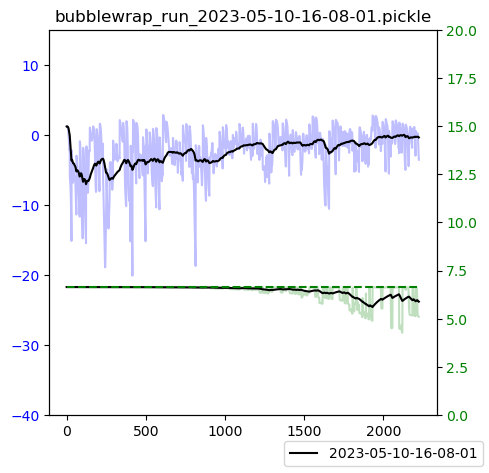

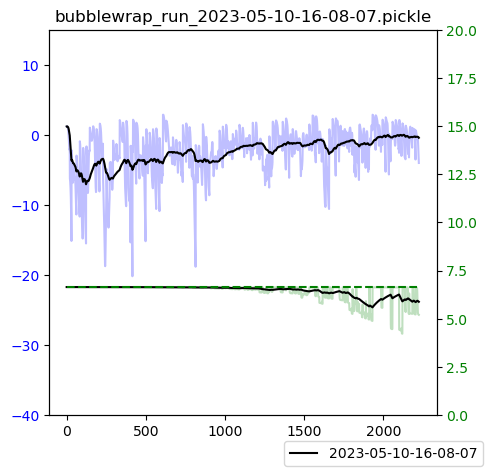

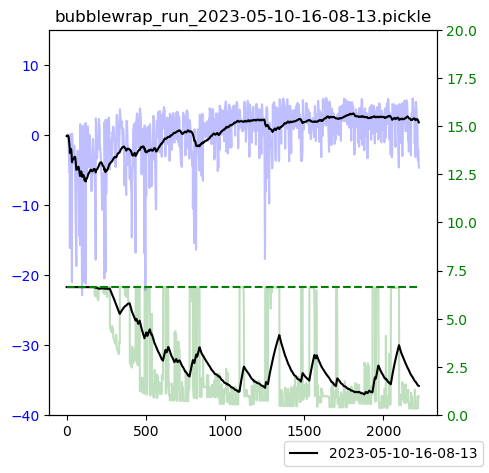

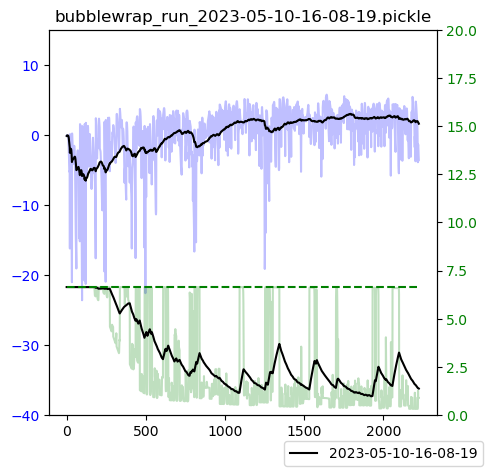

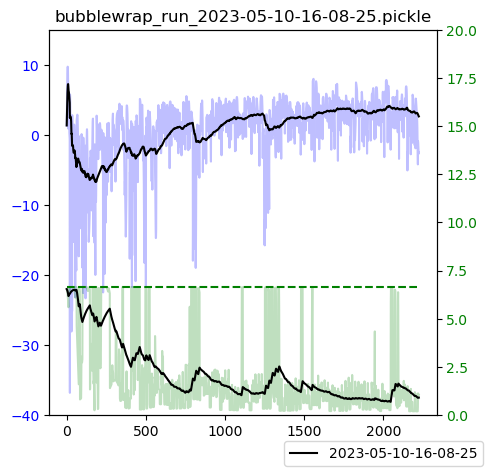

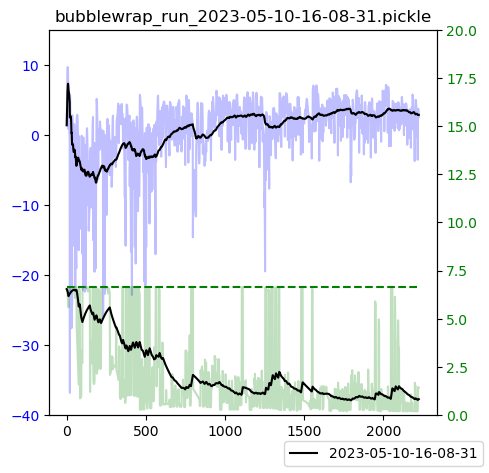

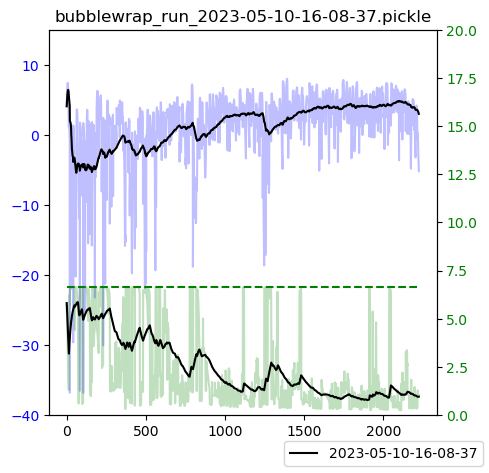

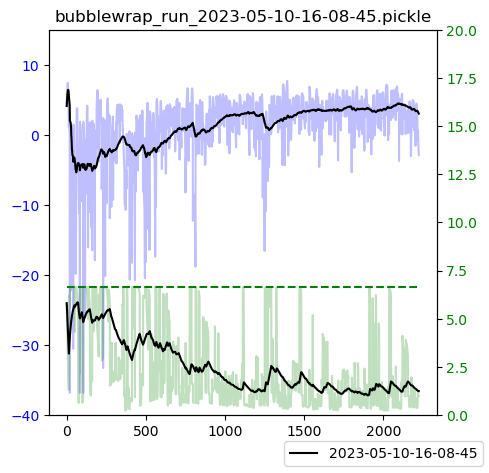

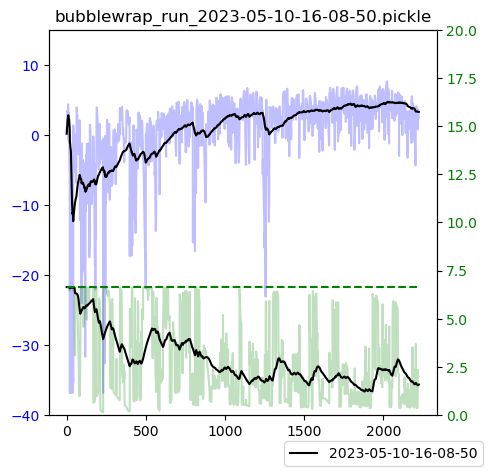

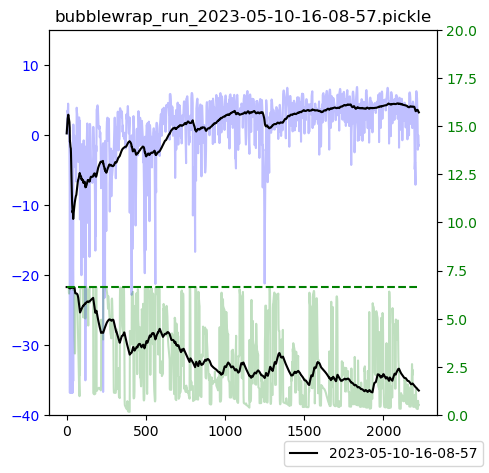

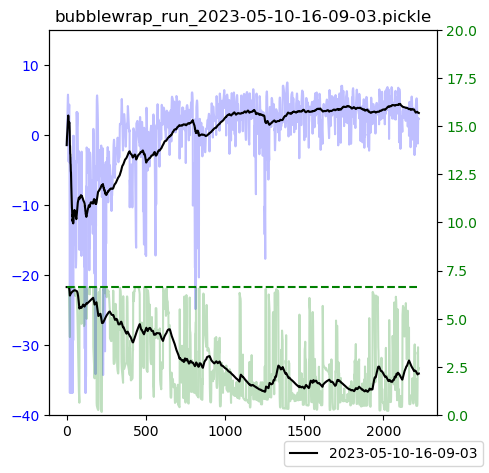

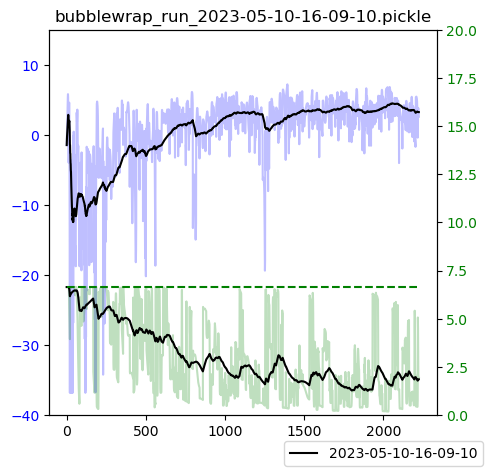

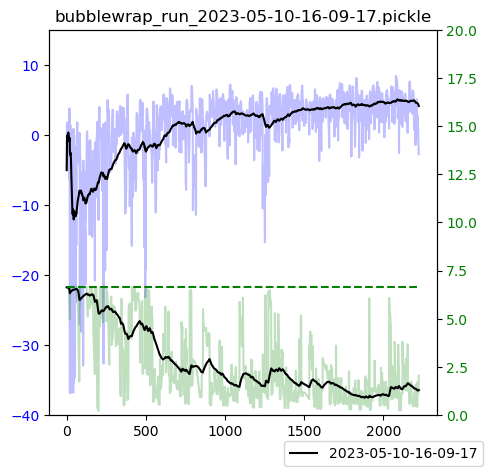

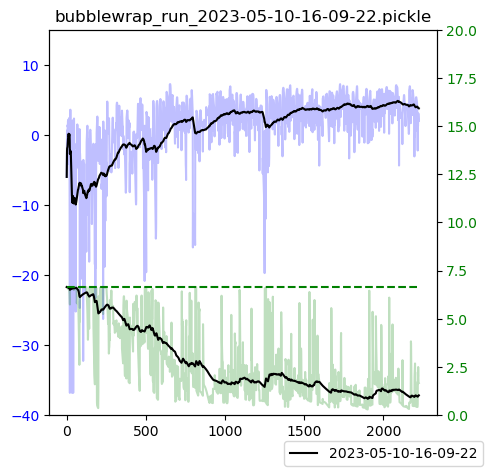

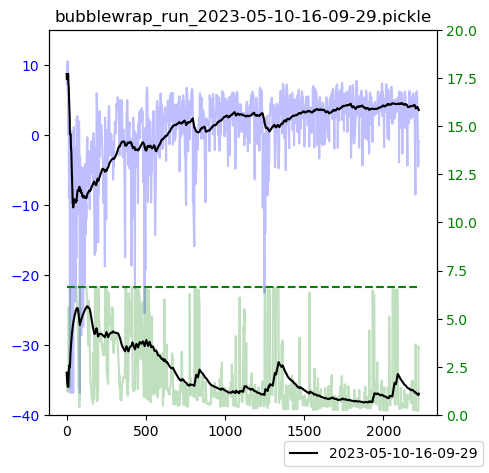

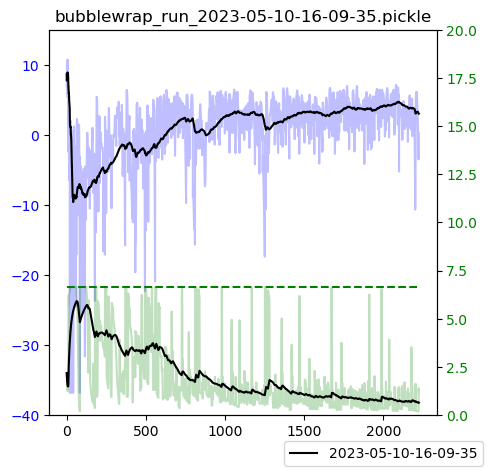

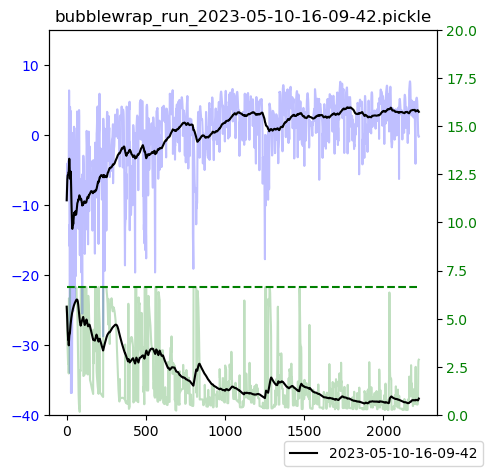

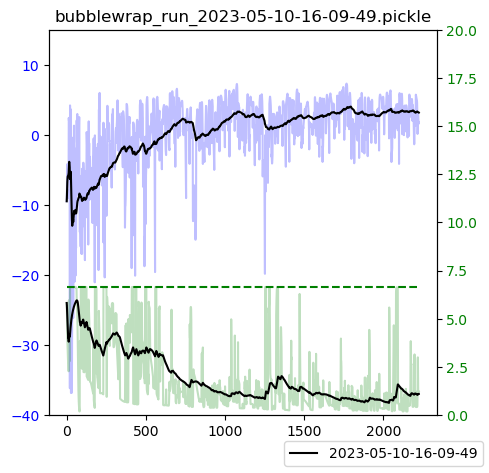

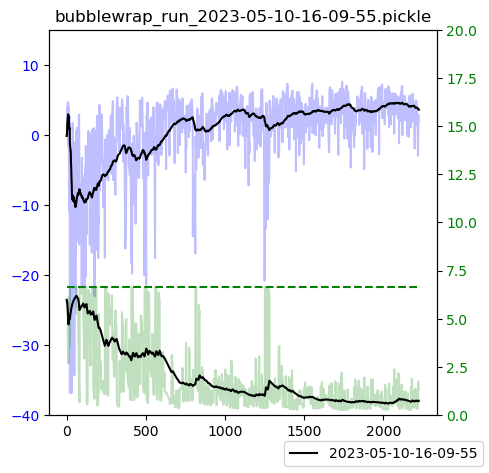

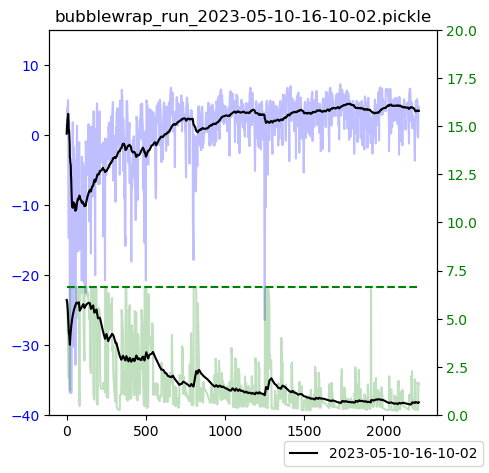

In [434]:
files = [
 'bubblewrap_run_2023-05-10-16-08-01.pickle',
 'bubblewrap_run_2023-05-10-16-08-07.pickle',
 'bubblewrap_run_2023-05-10-16-08-13.pickle',
 'bubblewrap_run_2023-05-10-16-08-19.pickle',
 'bubblewrap_run_2023-05-10-16-08-25.pickle',
 'bubblewrap_run_2023-05-10-16-08-31.pickle',
 'bubblewrap_run_2023-05-10-16-08-37.pickle',
 'bubblewrap_run_2023-05-10-16-08-45.pickle',
 'bubblewrap_run_2023-05-10-16-08-50.pickle',
 'bubblewrap_run_2023-05-10-16-08-57.pickle',
 'bubblewrap_run_2023-05-10-16-09-03.pickle',
 'bubblewrap_run_2023-05-10-16-09-10.pickle',
 'bubblewrap_run_2023-05-10-16-09-17.pickle',
 'bubblewrap_run_2023-05-10-16-09-22.pickle',
 'bubblewrap_run_2023-05-10-16-09-29.pickle',
 'bubblewrap_run_2023-05-10-16-09-35.pickle',
 'bubblewrap_run_2023-05-10-16-09-42.pickle',
 'bubblewrap_run_2023-05-10-16-09-49.pickle',
 'bubblewrap_run_2023-05-10-16-09-55.pickle',
 'bubblewrap_run_2023-05-10-16-10-02.pickle'
]

for file in files:
    with open(file, "rb") as fhan:
        br = pickle.load(fhan)
    plot_figure_5([br,])
    plt.gca().set_title(file)

0.1332428500817291
0.02952450198706469
0.11061841472142708
-0.5199005022421082
-0.19809680854431555
-0.5613985310067062
-0.06325680313273896
0.3304036971661679
-0.7877471269072718
-0.11253303381058055
-0.00026797997218741543
-0.043780683435617807
-0.31231165293904173
0.15722145037829405
-0.9049498107129588
-0.617854191098643
-2.8238748584314983
-3.221649001182905
-7.952480568641594
-6.258528687157312


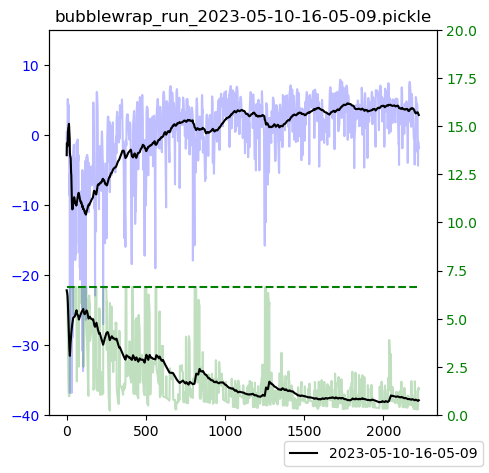

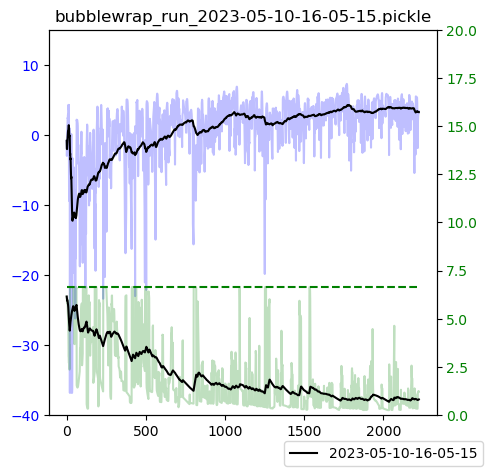

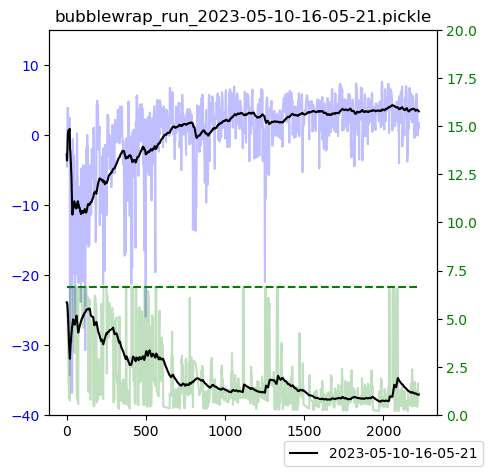

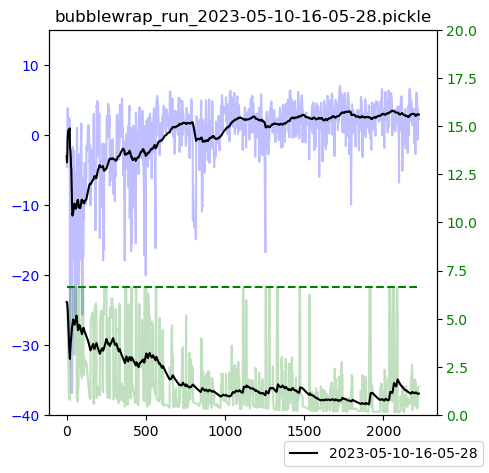

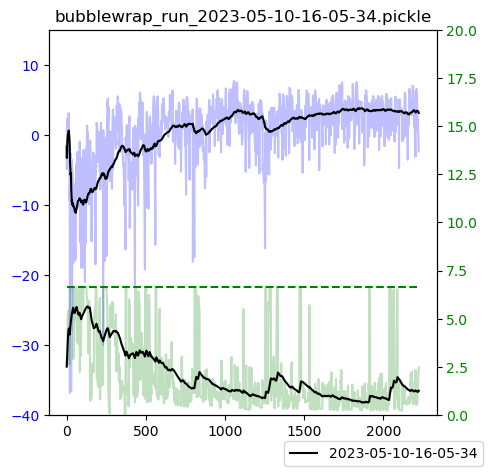

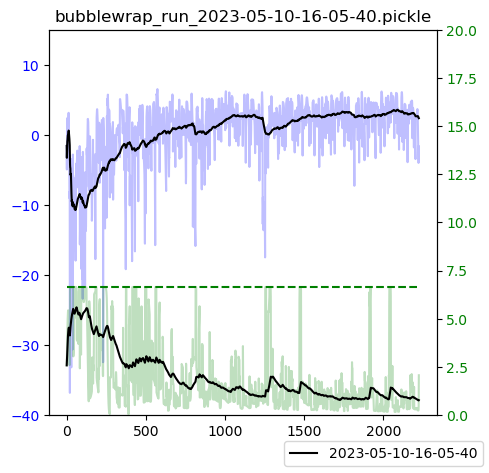

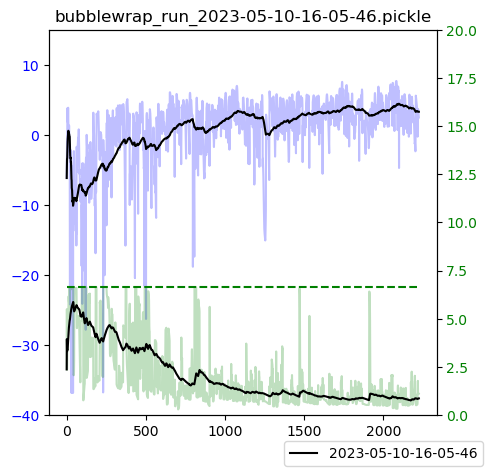

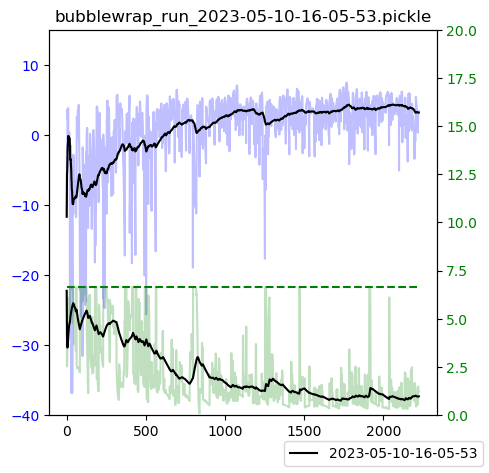

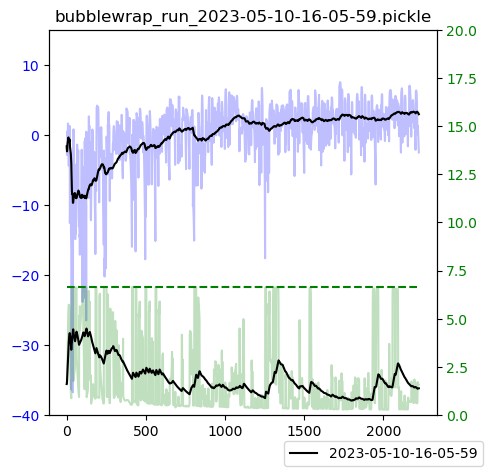

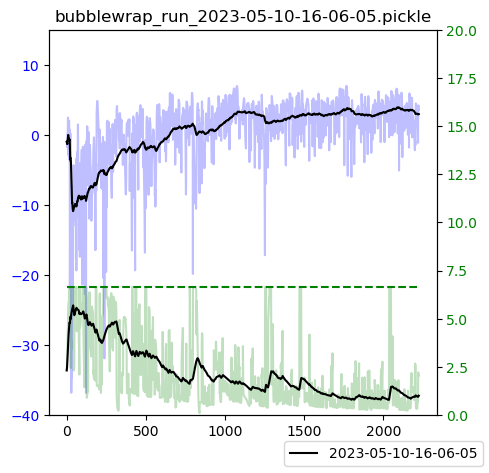

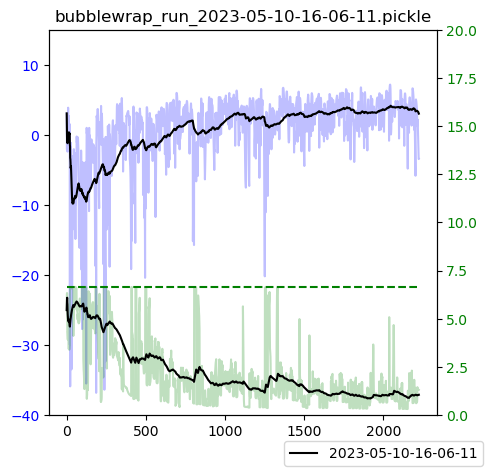

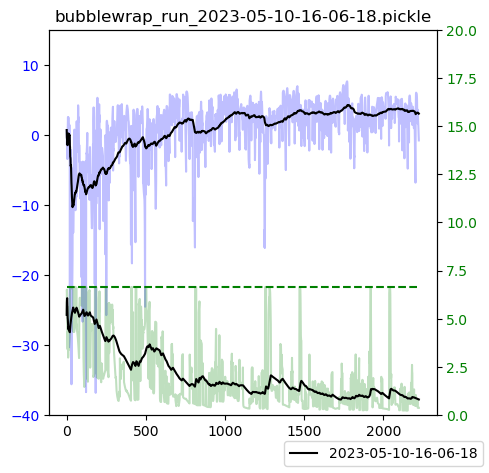

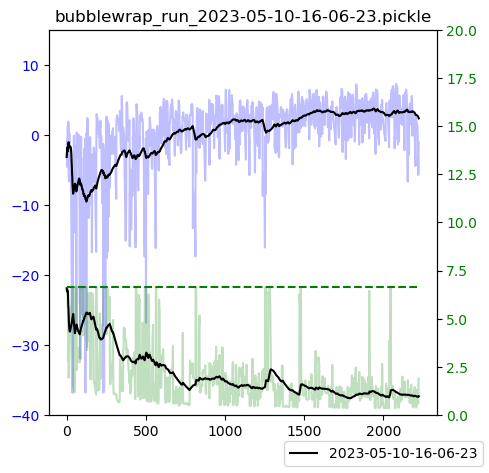

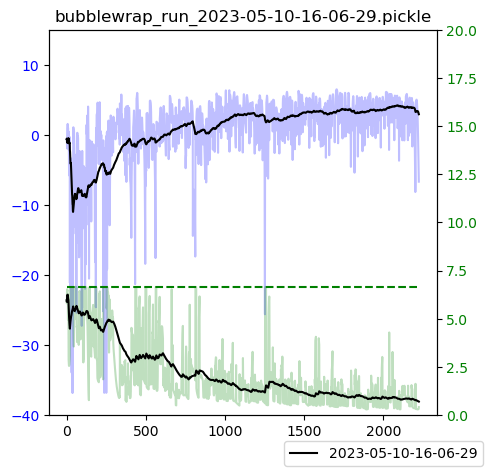

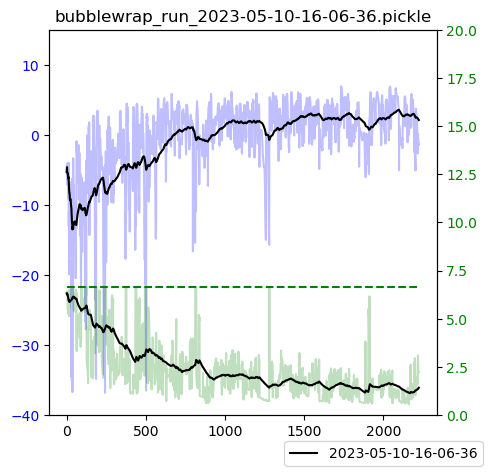

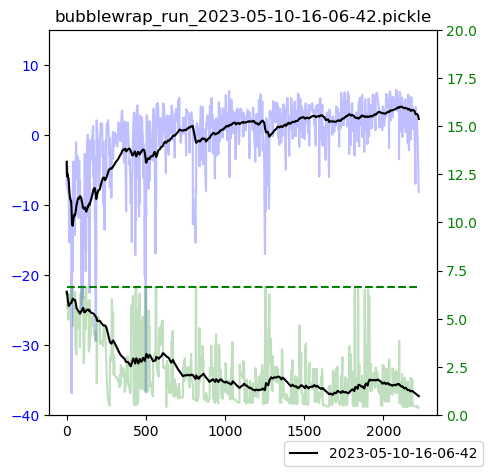

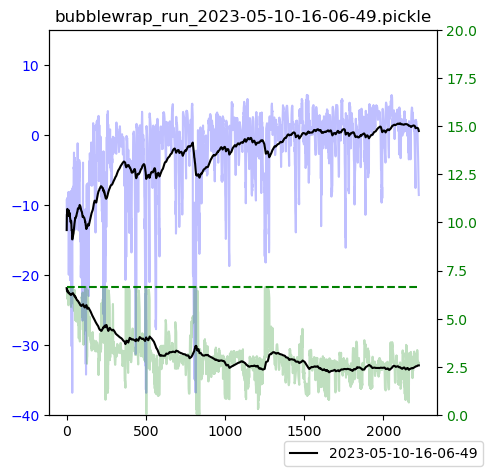

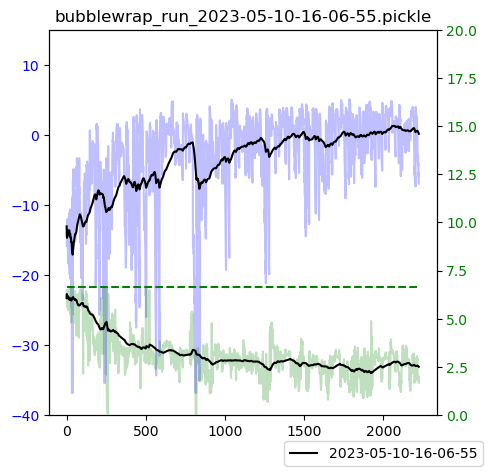

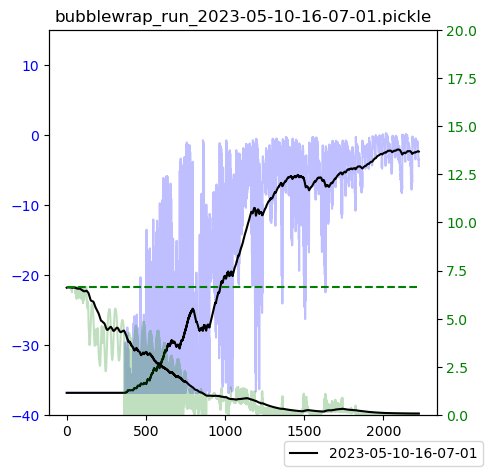

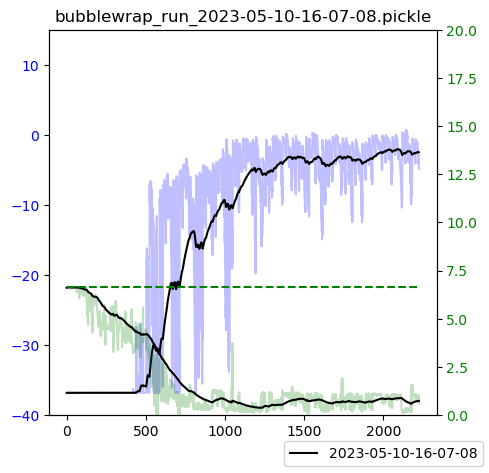

In [435]:
files = [
 'bubblewrap_run_2023-05-10-16-05-09.pickle',
 'bubblewrap_run_2023-05-10-16-05-15.pickle',
 'bubblewrap_run_2023-05-10-16-05-21.pickle',
 'bubblewrap_run_2023-05-10-16-05-28.pickle',
 'bubblewrap_run_2023-05-10-16-05-34.pickle',
 'bubblewrap_run_2023-05-10-16-05-40.pickle',
 'bubblewrap_run_2023-05-10-16-05-46.pickle',
 'bubblewrap_run_2023-05-10-16-05-53.pickle',
 'bubblewrap_run_2023-05-10-16-05-59.pickle',
 'bubblewrap_run_2023-05-10-16-06-05.pickle',
 'bubblewrap_run_2023-05-10-16-06-11.pickle',
 'bubblewrap_run_2023-05-10-16-06-18.pickle',
 'bubblewrap_run_2023-05-10-16-06-23.pickle',
 'bubblewrap_run_2023-05-10-16-06-29.pickle',
 'bubblewrap_run_2023-05-10-16-06-36.pickle',
 'bubblewrap_run_2023-05-10-16-06-42.pickle',
 'bubblewrap_run_2023-05-10-16-06-49.pickle',
 'bubblewrap_run_2023-05-10-16-06-55.pickle',
 'bubblewrap_run_2023-05-10-16-07-01.pickle',
 'bubblewrap_run_2023-05-10-16-07-08.pickle'
]

for file in files:
    with open(file, "rb") as fhan:
        br = pickle.load(fhan)
    plot_figure_5([br,])
    plt.gca().set_title(file)

-4.160225015726599
-4.196293364864548
-0.38069889399749934
-0.639253786086373
0.4298965370673984
0.47064799898435794
0.6528154713259897
0.44907366462443976
0.5828127480608591
0.4624011019281453
0.5930354449177453
0.6610476712967595
1.1160294670451179
0.8356641069541326
0.8499269893164314
0.74203034944335
0.7968232921067728
0.5302566699855018
0.8729685943258874
0.8547341796873105


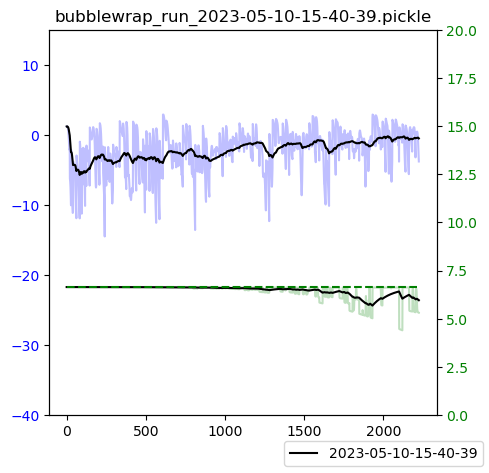

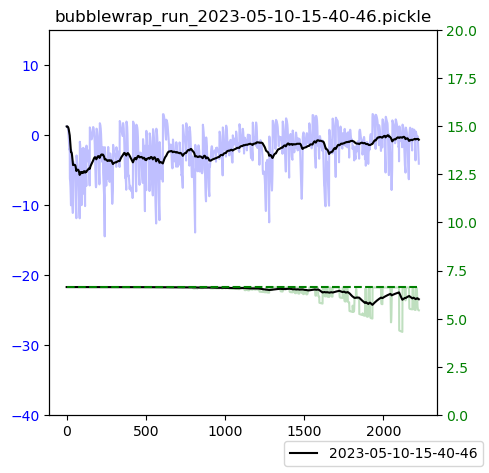

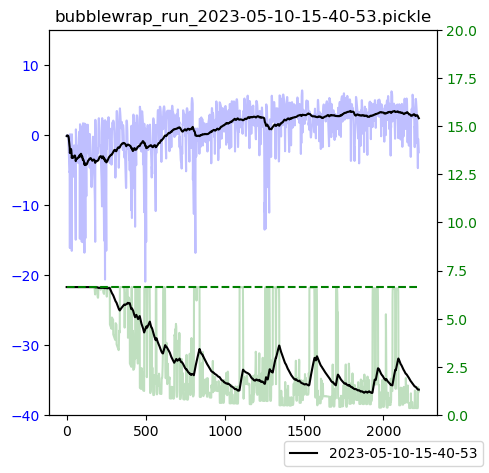

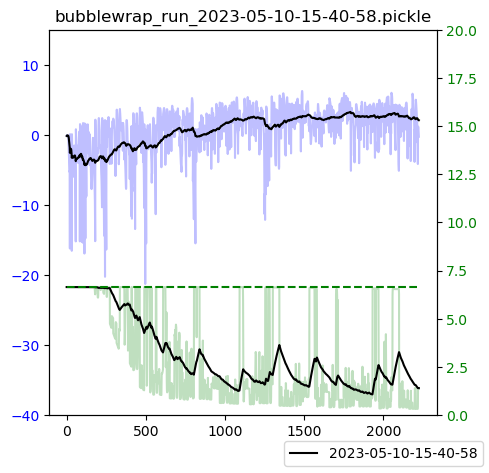

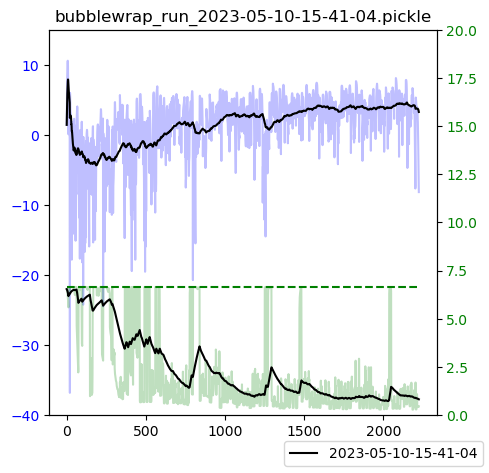

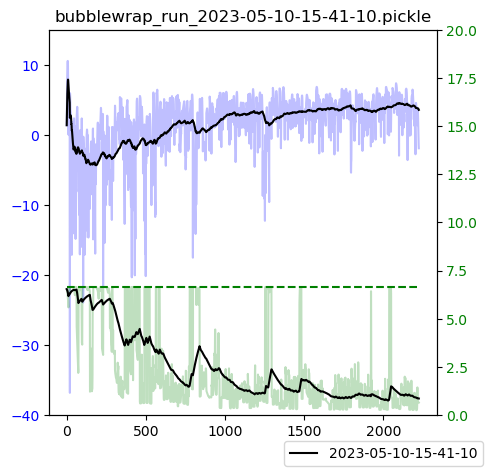

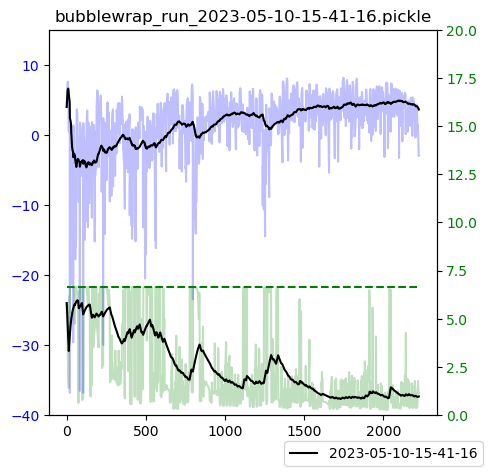

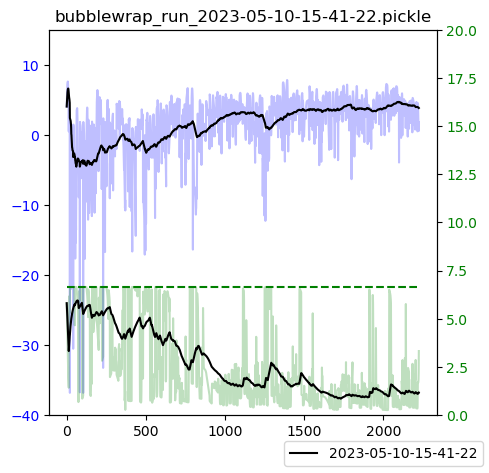

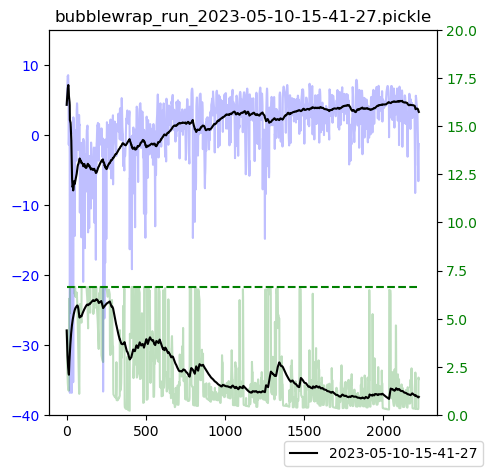

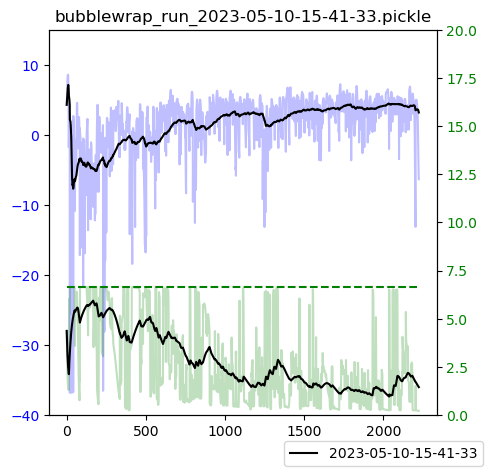

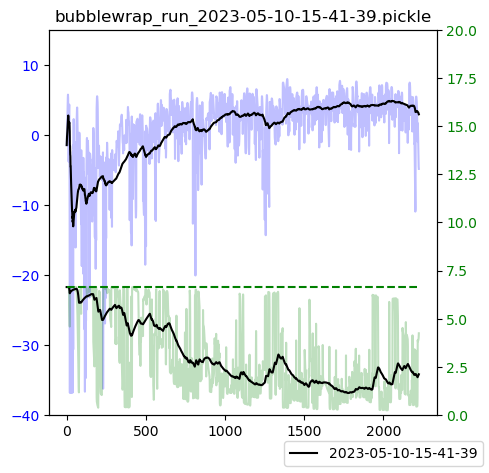

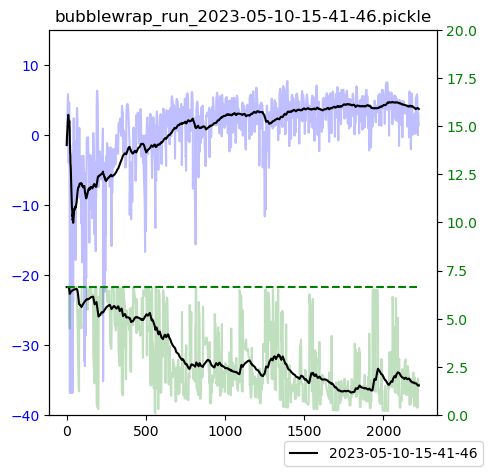

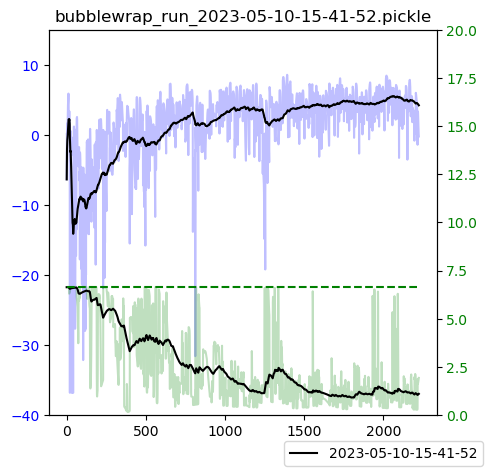

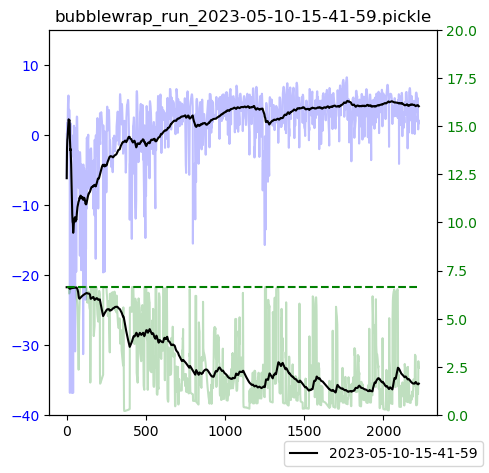

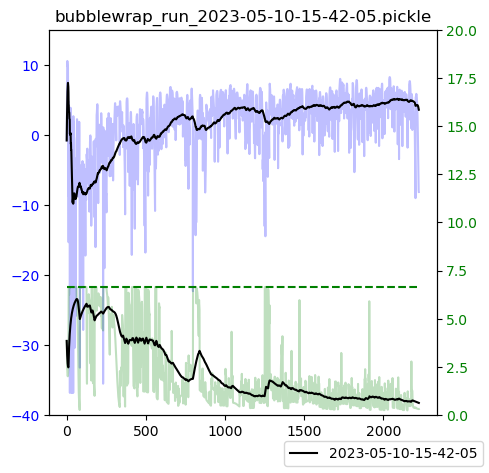

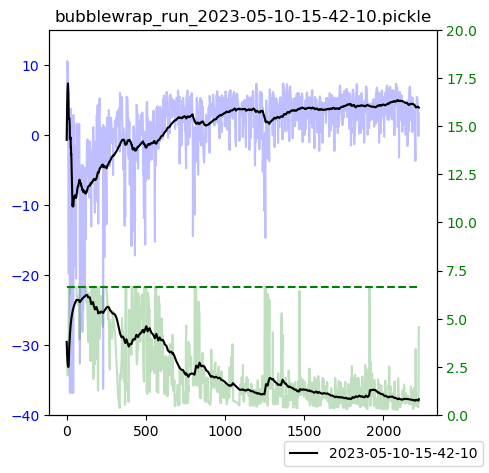

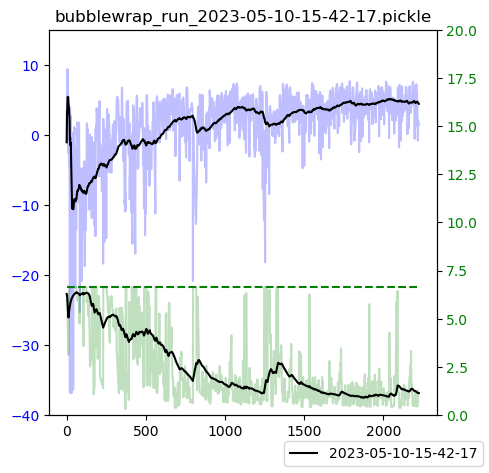

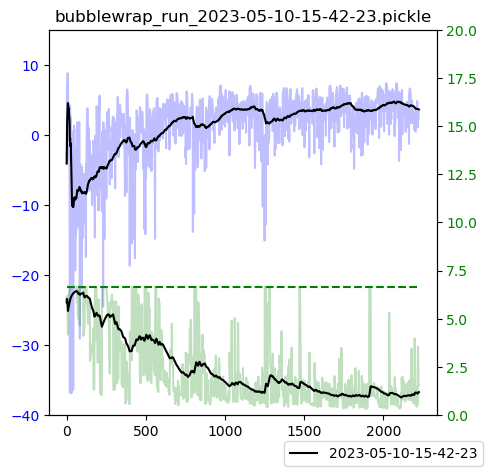

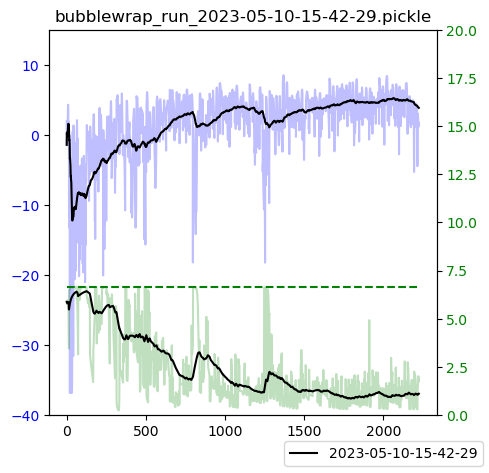

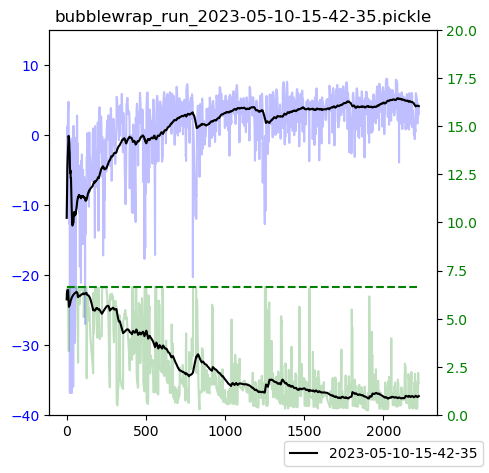

In [436]:
files = [
'bubblewrap_run_2023-05-10-15-40-39.pickle',
 'bubblewrap_run_2023-05-10-15-40-46.pickle',
 'bubblewrap_run_2023-05-10-15-40-53.pickle',
 'bubblewrap_run_2023-05-10-15-40-58.pickle',
 'bubblewrap_run_2023-05-10-15-41-04.pickle',
 'bubblewrap_run_2023-05-10-15-41-10.pickle',
 'bubblewrap_run_2023-05-10-15-41-16.pickle',
 'bubblewrap_run_2023-05-10-15-41-22.pickle',
 'bubblewrap_run_2023-05-10-15-41-27.pickle',
 'bubblewrap_run_2023-05-10-15-41-33.pickle',
 'bubblewrap_run_2023-05-10-15-41-39.pickle',
 'bubblewrap_run_2023-05-10-15-41-46.pickle',
 'bubblewrap_run_2023-05-10-15-41-52.pickle',
 'bubblewrap_run_2023-05-10-15-41-59.pickle',
 'bubblewrap_run_2023-05-10-15-42-05.pickle',
 'bubblewrap_run_2023-05-10-15-42-10.pickle',
 'bubblewrap_run_2023-05-10-15-42-17.pickle',
 'bubblewrap_run_2023-05-10-15-42-23.pickle',
 'bubblewrap_run_2023-05-10-15-42-29.pickle',
 'bubblewrap_run_2023-05-10-15-42-35.pickle',
]

for file in files:
    with open(file, "rb") as fhan:
        br = pickle.load(fhan)
    plot_figure_5([br,])
    plt.gca().set_title(file)

0.8885686677010769
0.9142603494270576
0.5049734431304684
0.41533428696720387
0.7053271847569813
0.7495382098805683
0.8250426184389008
0.5192711615951922
1.0020182145014274
0.44264269504698106
0.7294386858456168
0.5036479507802198
0.7675594662227154
0.5876644042670938
0.16430550901211394
0.007601670731023358
-1.9966854383946095
-1.5444849835224481
-8.901626290722797
-6.3439139038571035


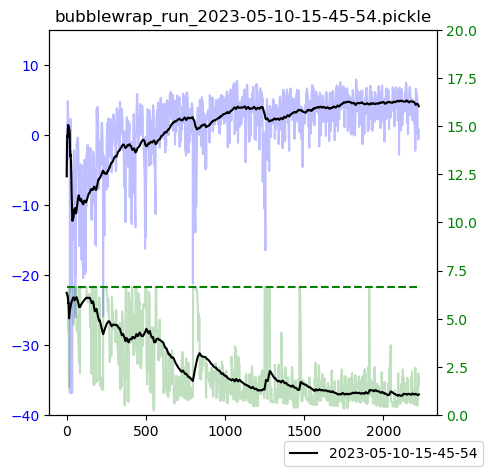

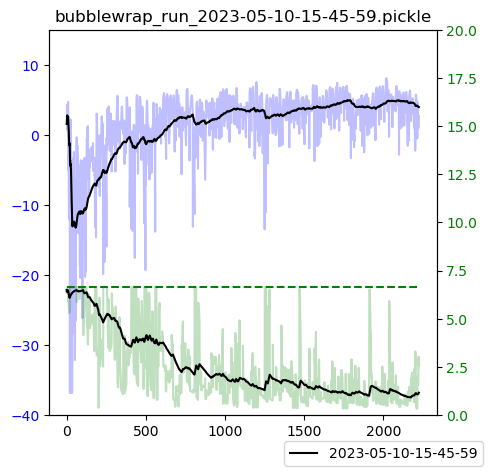

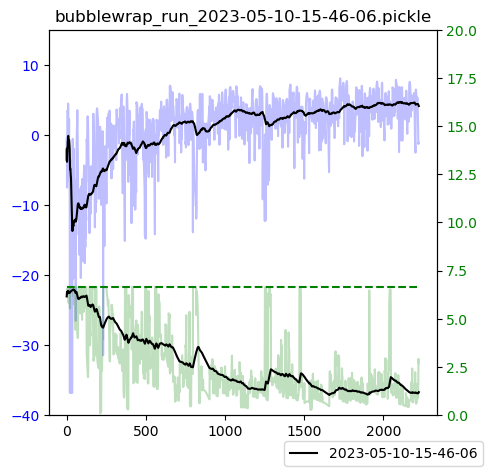

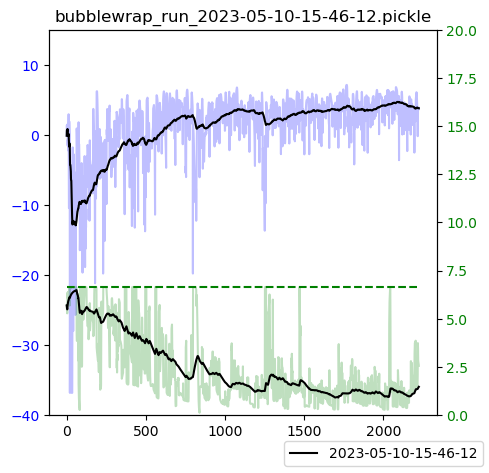

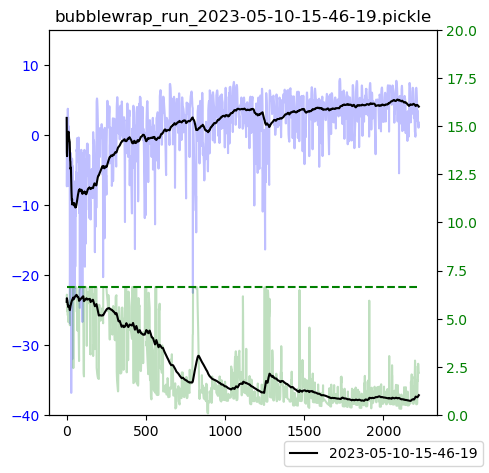

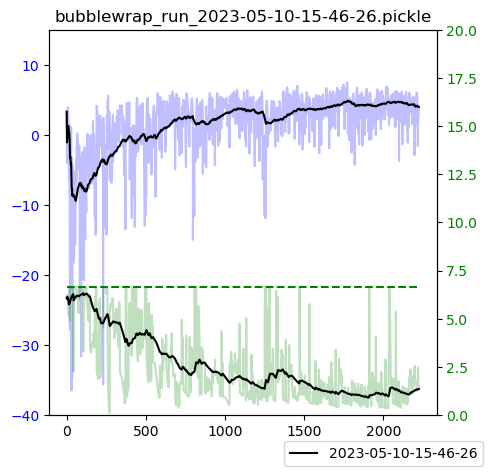

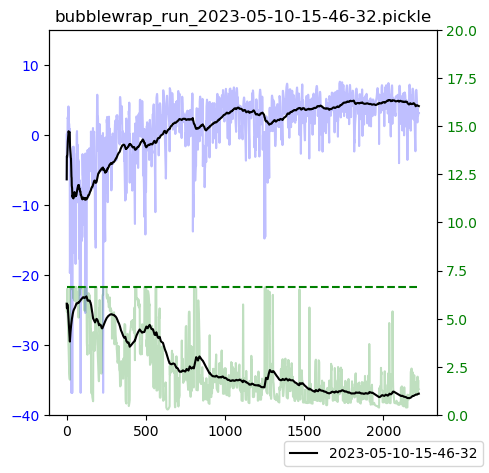

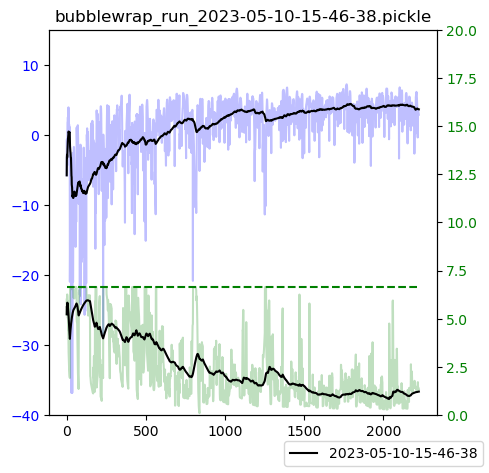

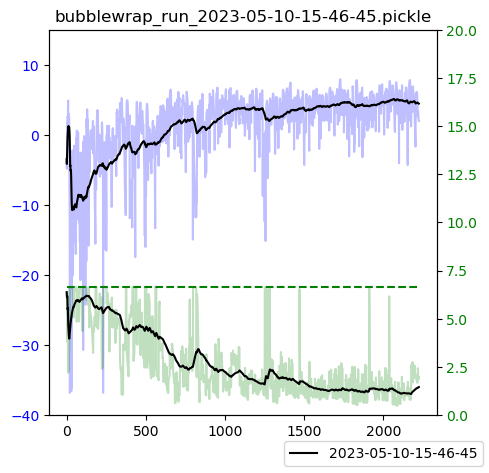

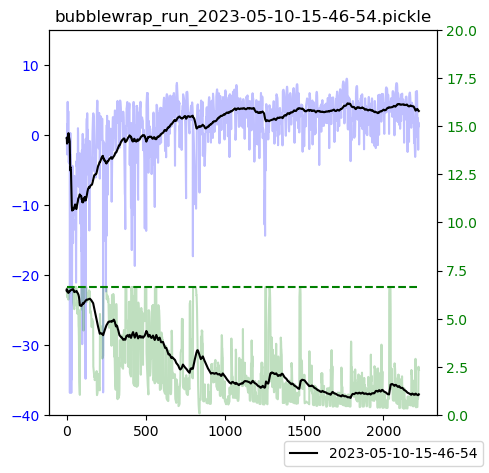

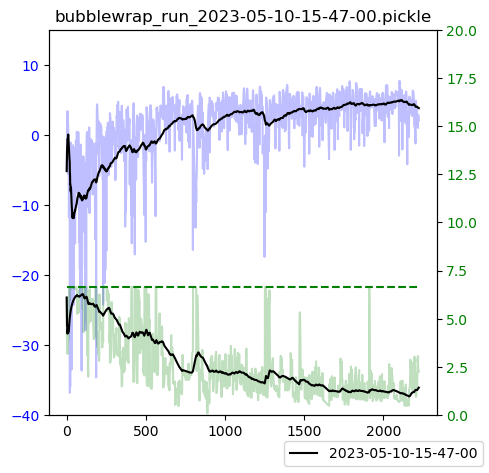

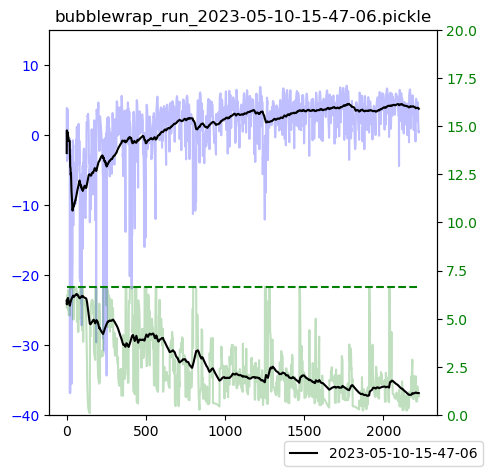

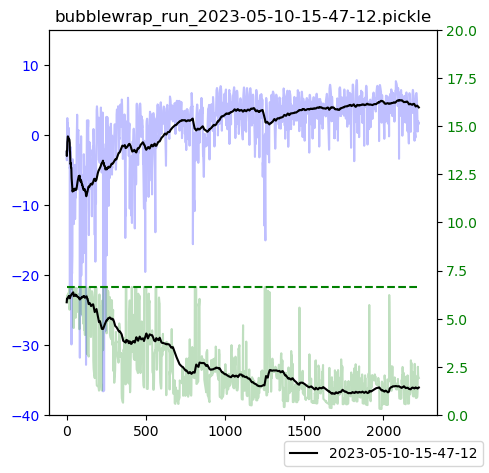

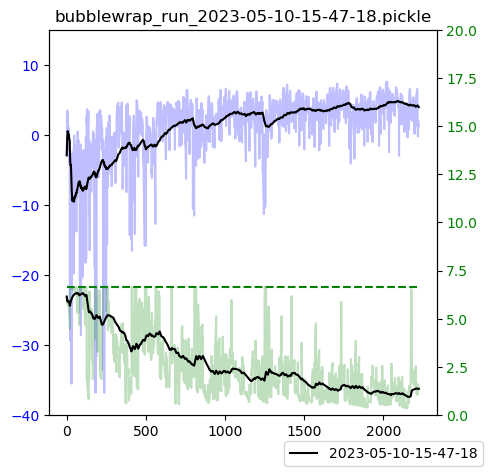

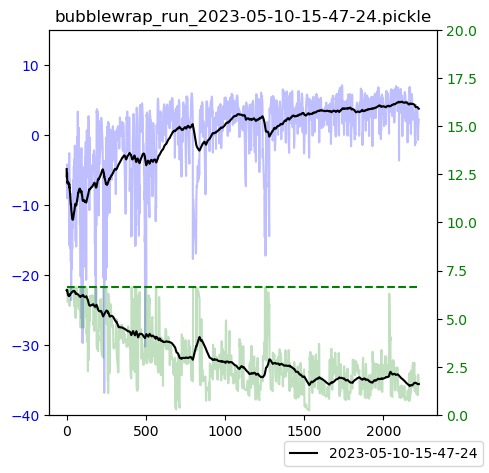

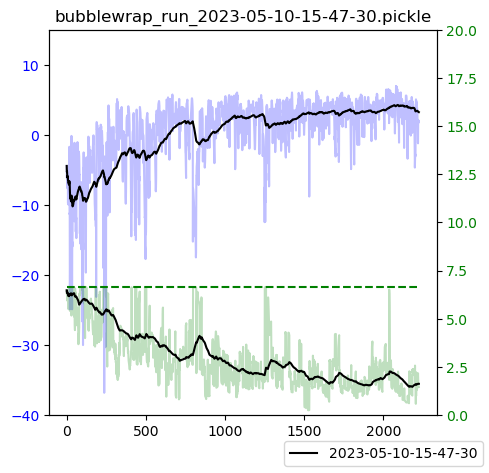

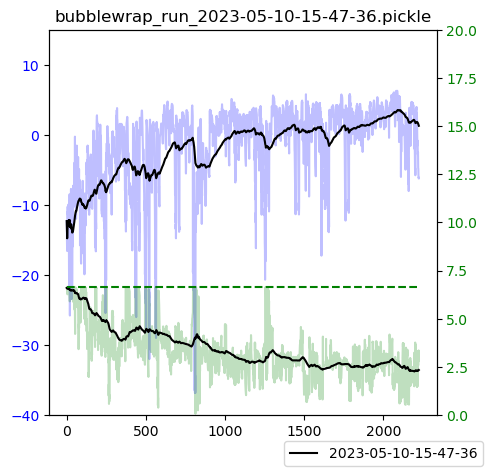

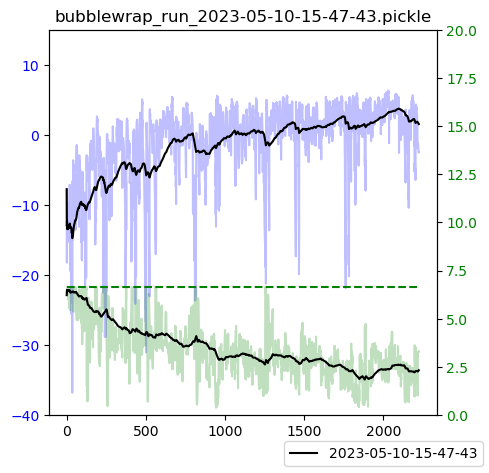

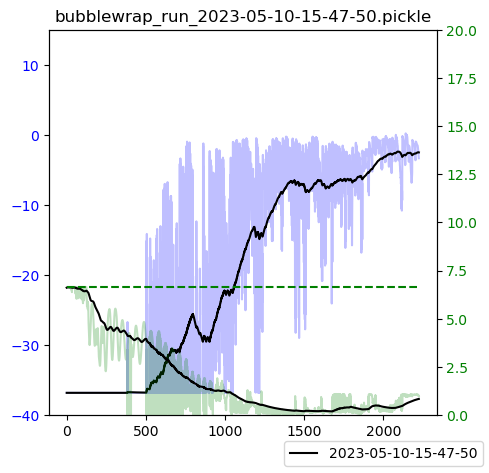

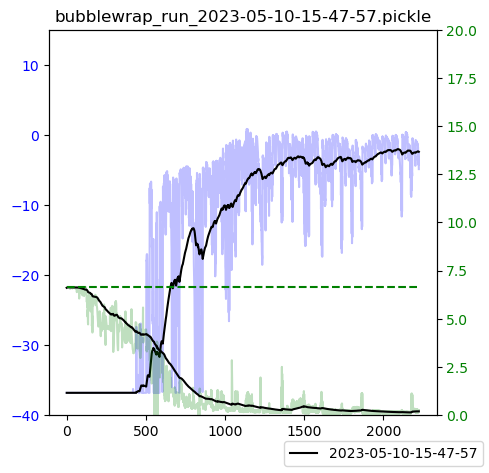

In [437]:
files = [
 'bubblewrap_run_2023-05-10-15-45-54.pickle',
 'bubblewrap_run_2023-05-10-15-45-59.pickle',
 'bubblewrap_run_2023-05-10-15-46-06.pickle',
 'bubblewrap_run_2023-05-10-15-46-12.pickle',
 'bubblewrap_run_2023-05-10-15-46-19.pickle',
 'bubblewrap_run_2023-05-10-15-46-26.pickle',
 'bubblewrap_run_2023-05-10-15-46-32.pickle',
 'bubblewrap_run_2023-05-10-15-46-38.pickle',
 'bubblewrap_run_2023-05-10-15-46-45.pickle',
 'bubblewrap_run_2023-05-10-15-46-54.pickle',
 'bubblewrap_run_2023-05-10-15-47-00.pickle',
 'bubblewrap_run_2023-05-10-15-47-06.pickle',
 'bubblewrap_run_2023-05-10-15-47-12.pickle',
 'bubblewrap_run_2023-05-10-15-47-18.pickle',
 'bubblewrap_run_2023-05-10-15-47-24.pickle',
 'bubblewrap_run_2023-05-10-15-47-30.pickle',
 'bubblewrap_run_2023-05-10-15-47-36.pickle',
 'bubblewrap_run_2023-05-10-15-47-43.pickle',
 'bubblewrap_run_2023-05-10-15-47-50.pickle',
 'bubblewrap_run_2023-05-10-15-47-57.pickle'
]

for file in files:
    with open(file, "rb") as fhan:
        br = pickle.load(fhan)
    plot_figure_5([br,])
    plt.gca().set_title(file)

# SVG stuff

In [524]:
x_0 = 173.352
x_2000 = 264.941
x_final = 275.245
steps_in_jpca_data = 2268

x_steps_per_pixel = 2000/(x_2000-x_0)
steps_in_graph = (x_final-x_0)*x_steps_per_pixel

estimated_m = steps_in_jpca_data - steps_in_graph

print(f"{steps_per_pixel = }")
print(f"{steps_in_graph = }")
print(f"{estimated_m = }")
print(f"{estimated_m/21 = }")

steps_per_pixel = 21.836683444518453
steps_in_graph = 2225.0051862123187
estimated_m = 42.99481378768132
estimated_m/21 = 2.047372085127682


In [589]:
tds = \
"""m 0,0 0.273,48.446 0.456,24.259 0.182,2.183 0.091,-1.47 0.365,-10.107 0.365,4.17 0.091,-0.061 0.273,-6.277 0.183,-1.518 0.091,-0.166 1.003,19.128 1.093,12.309 0.547,6.727 0.365,2.635 0.273,1.827 0.092,-1.594 0.09,0.197 0.183,-1.764 0.182,0.15 0.092,-0.209 0.273,1.066 0.091,-0.056 0.091,-1.06 0.091,0.631 0.183,-1.638 0.091,-1.818 0.091,0.348 0.274,1.687 0.09,-0.529 0.092,0.182 0.729,4.227 0.547,-0.884 0.182,-0.996 0.092,0.574 0.09,-0.752 0.365,1.711 1.003,4.718 0.182,0.05 0.274,-0.179 0.182,0.238 0.091,0.167 0.365,-4.892 0.091,0.17 0.091,-0.126 0.091,0.542 0.091,-1.417 0.274,0.896 0.091,0.072 0.182,-0.902 0.183,-1.982 0.091,0.432 0.091,-0.963 0.091,0.31 0.091,-0.068 0.091,-0.188 0.091,-1.358 0.092,0.183 0.091,-0.625 0.091,0.196 0.182,-0.725 0.091,0.329 0.092,-0.142 0.09,0.303 0.274,-0.759 0.091,-0.017 0.274,-2.423 0.091,-0.017 0.273,-2.896 0.092,0.082 0.364,1.98 0.547,3.205 0.365,1.275 0.364,1.425 0.638,1.712 0.729,3.036 0.457,1.078 0.273,0.692 0.091,0.459 0.091,-0.044 0.182,0.49 0.548,2.031 0.09,0.125 0.183,-0.313 0.182,-1.302 0.274,-2.336 0.729,2.422 0.729,2.984 0.274,0.317 0.911,2.833 0.729,2.68 0.73,0.868 0.09,-0.087 0.274,-3.43 0.091,-0.015 0.183,0.286 0.182,-1.668 0.091,0.107 0.547,-2.121 0.182,-0.01 0.456,-0.753 0.911,3.144 0.457,1.349 0.455,1.194 0.091,-0.253 0.183,0.317 0.729,1.757 0.091,-0.023 0.182,-0.292 0.183,0.269 0.456,1.147 0.09,-0.289 0.092,0.075 0.182,0.195 0.729,0.799 0.274,-0.028 0.547,-0.46 0.82,1.739 0.729,0.104 0.456,-0.048 0.729,1.355 0.456,0.53 0.547,1.171 0.091,0.199 0.182,-0.399 0.547,-0.266 0.274,-0.76 0.82,-2.792
m 39.102,118.227 0.183,0.078 0.273,0.591 0.912,2.28 0.182,0.117 0.365,0.023 0.09,0.094 0.183,-0.829 0.273,0.223 0.274,0.24 0.182,-0.196 0.638,-1.95 0.274,-0.35 0.091,0.015 0.182,-0.375 0.274,0.452 0.456,0.8 0.09,-0.08 0.274,-1.146 0.091,0.097 0.274,0.377 0.273,-0.308 0.091,0.01 0.912,2.626 0.182,-0.017 1.003,1.791 0.638,0.78 0.091,-0.017 0.182,-0.144 0.73,1.244 0.182,-0.799 0.182,-0.267 0.183,0.052 0.273,0.139 0.091,-0.129 0.365,-1.172 0.091,-0.001 0.182,-0.795 0.273,-1.371 0.092,0.092 0.091,-0.181 0.273,0.555 0.639,1.546 0.09,-0.141 0.821,1.263 0.274,-0.789 0.182,-0.051 0.547,0.33 0.182,-0.213 0.273,-0.914 0.092,0.109 0.364,0.651 0.092,-0.124 0.911,1.636 0.182,-0.301 0.456,-1.452 0.183,0.149 0.637,1.311 0.73,1.656 0.547,0.536 0.091,0.016 0.091,-0.166 0.911,1.292 0.183,0.109 0.273,-0.005 0.456,0.185 0.182,-0.2 0.638,0.41 0.456,0.576 0.182,-0.116 0.183,-0.487 0.364,-1.313 0.274,0.178 1.276,1.604 0.182,-0.243 0.182,-0.181 0.912,1.547 0.365,0.249 0.547,0.817 0.182,-0.329 0.273,0.188 0.548,0.607 0.182,-0.263 0.547,0.075 0.273,-0.122 0.912,1.196 0.182,-0.074 0.729,0.595 0.182,-0.428 0.274,-0.073 0.365,0.179 0.364,0.169 0.182,-0.203 0.183,-0.171 0.456,0.466 0.364,0.131 0.638,-0.272 0.547,-0.787 0.273,-0.303 0.092,-0.239 0.82,1.137 0.091,-0.015 0.182,-0.456 0.183,-0.505 0.274,-0.164 0.273,-0.016 0.182,-0.221 0.365,0.458 0.455,0.612 0.274,0.199 0.638,0.967 0.183,-1.485 0.273,-0.26 0.182,0.092 0.092,-0.02 0.273,-0.389 0.091,-0.025 0.365,-0.848 0.273,-0.689 0.182,-0.028 0.183,-0.229 0.455,0.632 0.547,0.897 0.547,0.372 0.183,-0.029 0.091,-0.229 0.82,1.147 0.274,-0.234
m 81.492,131.263 0.729,0.546 0.182,-0.377 0.274,-0.012 0.547,0.178 0.729,-0.705 0.364,-0.051 0.183,-0.186 0.364,-0.421 0.274,0.084 0.82,0.708 0.091,0.009 0.092,-0.214 0.82,1.067 0.091,-0.048 0.821,0.614 0.82,0.611 0.273,0.161 0.456,-0.215 0.547,-0.04 0.638,0.996 0.273,0.309 0.73,0.075 0.182,0.102 0.182,-0.191 0.365,0.102 0.729,0.425 0.182,-0.168 0.456,0.481 0.183,-0.013 1.093,0.151 0.365,-0.1 0.82,0.197 0.274,-0.259 0.273,-0.229 0.365,-0.134 0.456,-0.167 0.091,-0.302 0.729,0.821 0.183,-0.006 0.182,-0.123 0.455,0.441 0.274,0.21 0.091,-0.062 1.276,1.16 0.273,-0.332 0.274,-0.627 0.092,0.054 1.002,0.584 0.274,-0.232 0.728,-0.751 0.274,0.301 0.547,0.706 0.182,-0.112 0.274,-0.445 0.456,0.103 0.273,-0.434 0.182,-0.023 0.639,0.357 0.547,-0.391 0.364,-0.312 0.365,0.29 1.185,0.94 0.182,-0.134 0.091,-0.087 0.183,-0.387 0.273,0.095 0.73,0.486 0.364,-0.314 0.638,0.442 0.273,0.056 0.183,-0.168 0.273,-0.637 0.73,-2.002 0.364,-0.025 0.638,0.413 0.182,-0.2 0.274,-0.654 0.273,-0.223 0.365,0.269 0.091,-0.248 0.547,0.961 0.273,0.447 0.365,-0.03 0.546,0.637 0.092,0.001 0.274,-0.683 0.273,-0.114 0.274,-0.034 0.182,-0.201 0.182,-0.537 0.456,-1.623 0.182,-0.23 0.091,-0.246 1.458,1.203 0.183,-0.075 0.273,-0.263 0.091,-0.222 0.821,1.308 1.002,0.695 0.092,-0.244 0.729,0.761 0.182,-0.018 0.365,-0.324 0.274,-0.264 0.455,-0.329 0.73,0.505 0.182,-0.022 0.911,-1.104 0.091,0.083 0.639,0.65 0.181,-0.228 0.457,-0.892 0.456,0.146 0.182,-0.05 0.455,0.303 0.274,-0.051 0.273,-0.216 0.456,0.347 0.183,-0.029 0.273,-0.091 0.911,0.798 0.183,-0.05 h 0.273 l 0.365,-0.273 0.182,-0.052 0.911,0.738 0.274,-0.051
m 133.358,134.083 0.365,0.465 0.182,0.203 0.182,-0.053 0.274,0.202 0.456,0.422 0.273,-0.277 0.73,0.117 0.091,-0.258 0.09,0.072 0.821,0.853 0.182,-0.135 0.73,0.659 0.091,-0.353 0.091,0.067 0.638,0.412 0.73,0.255 0.364,0.527 0.273,-0.583 0.73,-0.439 0.638,-1.065 0.546,-0.403 0.73,0.127 0.729,0.176 0.274,-0.586 0.091,0.106 0.637,0.753 0.456,0.081 0.274,-0.27 0.273,-0.264 0.091,0.012 0.183,-0.184 0.456,0.145 0.364,0.157 0.183,-0.185 0.182,-0.233 0.455,0.293 0.092,0.032 0.182,-0.087 1.094,0.334 0.546,-0.27 0.092,0.051 0.091,-0.261 0.092,0.064 0.82,1.02 0.274,-0.458 0.273,-0.173 0.273,-0.001 0.274,0.023 0.82,0.674 0.638,-0.117 0.273,-0.391 0.092,0.117 0.82,0.828 0.365,0.037 0.364,-0.337 0.273,-0.492 0.092,-0.37 0.091,0.027 0.456,0.353 0.547,0.379 0.182,-0.098 0.182,-0.087 0.365,0.463 0.182,-0.105 0.73,0.045 0.182,-0.158 0.364,-0.673 0.547,-0.261 0.365,-0.114 0.365,0.091 0.273,0.147 0.091,-0.074 0.183,-0.294 0.637,-0.348 2.735,3.022 0.092,-0.091 0.182,-0.082 0.729,0.237 0.182,-0.142 0.456,0.366 0.274,0.254 0.364,-0.275 0.547,0.319 0.091,0.002 0.092,-0.32 0.09,0.03 0.547,0.292 0.183,-0.102 0.364,-0.908 0.365,-0.575 0.182,-0.041 0.912,0.245 0.182,-0.157 0.456,-0.626 0.273,-0.226 0.274,-0.005 1.003,1.283 0.182,-0.008 0.638,-0.019 0.091,-0.22 0.912,1.091 0.182,-0.099 0.729,0.561 0.273,-0.58 0.274,-0.114 0.639,0.378 0.364,0.131 0.547,-0.147 0.729,0.384 0.82,-0.393 0.183,-0.151 0.182,-0.311 0.456,0.583 0.273,0.306 0.183,-0.085 0.455,0.076 0.365,0.146 0.182,-0.195 0.82,-0.008 0.456,-0.664 0.82,-0.552 0.274,0.092 1.185,0.478 0.091,-0.104 0.091,-0.32 0.092,0.048 1.184,0.715
m 185.042,137.934 0.183,-0.087 0.364,0.551 0.183,-0.135 0.729,-0.111 0.182,-0.21 0.365,-0.633 0.455,0.107 0.183,-0.134 1.003,0.532 0.183,-0.212 0.546,0.274 0.091,-0.197 1.824,1.888 0.181,-0.103 0.456,0.036 0.365,-0.211 0.365,-0.416 0.364,-0.061 0.365,-0.161 0.638,0.437 0.273,-0.015 0.821,-0.817 0.09,-0.143 0.913,1.12 0.273,-0.104 0.638,0.311 0.182,-0.155 0.365,0.111 0.546,0.325 0.274,-0.097 0.456,0.388 0.091,0.084 0.182,-0.353 0.456,0.273 0.638,0.458 0.274,-0.037 0.365,0.419 0.091,-0.29 0.82,0.902 0.183,-0.105 0.273,0.009 0.547,0.128
"""
point_0 = np.array([173.352, 325.858])
point_end =  np.array([275.245, 349.688])
y_0 = 357.236
y_1 = 244.923
y_1_value = 10
y_0_value = -40

In [602]:
tds = \
"""m 0,0 0.182,62.789 0.274,15.65 0.273,5.054 0.365,2.937 0.364,1.802 0.274,0.331 0.182,-0.049 0.547,1.175 0.273,0.26 0.456,-0.225 0.091,-0.198 0.092,0.125 0.091,-0.184 0.273,0.188 0.182,0.028 0.456,-0.356 0.273,-0.442 0.639,-1.639 0.456,-1.298 0.09,0.162 0.73,0.919 0.091,-0.147 0.729,0.567 0.274,-0.012 0.547,-0.64 0.364,-1.042 0.547,-2.045 0.092,0.156 0.273,0.412 0.091,-0.087 1.914,-9.703 0.091,0.265 0.73,1.68 0.091,0.021 0.091,-0.142 0.182,0.31 0.547,1.105 0.091,0.015 0.091,-0.204 0.639,1.269 0.182,0.152 0.182,-0.281 0.911,1.718 0.183,0.096 0.182,-0.251 0.638,-1.146 0.274,0.196 1.002,0.805 0.092,-0.073 0.273,-0.609 0.183,-0.154 0.82,-2.761 0.456,0.83 0.091,0.018 0.365,-0.695 0.09,-0.039 0.183,-0.6 0.091,-0.408 0.456,0.835 0.182,0.096 0.091,-0.097 0.365,0.542 0.091,-0.002 0.82,-2.157 0.092,0.09 0.546,0.6 0.092,0.071 0.729,-2.705 0.456,-1.673 0.273,0.457 0.091,-0.109 0.273,-0.753 0.092,-0.031 0.365,0.881 0.182,-0.32 0.456,1.059 0.273,0.113 0.182,-0.125 0.274,0.415 0.091,-0.055 0.182,-0.174 0.183,0.02 0.82,-0.792 0.182,0.034 0.638,-1.078 0.274,-0.119 0.182,-0.283 0.729,-2.114 0.091,0.072 0.183,0.039 0.182,-0.306 0.82,-2.685 3.282,-13.574 0.273,-0.256 0.365,-0.733 0.729,-1.572 0.183,0.648 0.364,1.746 0.091,-0.072 0.547,-1.218 1.459,-4.012 1.732,-5.146 0.364,1.234 0.183,0.1 0.182,0.21 0.182,-0.123 0.092,0.07 0.273,1.101 0.182,-0.424 0.274,0.737 0.091,-0.165 0.091,-0.302 0.547,1.555 0.364,0.261 0.183,-0.028 0.273,0.966 0.183,-0.497 0.273,0.633 0.182,-0.214 0.274,-0.145 0.456,-0.676 1.64,-3.069 0.73,-1.49 0.091,-0.042 0.091,0.083 0.273,0.552 0.274,0.079
m 47.947,41.568 0.365,-0.426 0.546,-0.937 0.183,1.021 0.091,-0.063 0.182,-0.44 0.183,1.012 0.09,-0.05 0.365,-0.804 0.82,-1.821 0.274,0.459 0.273,-0.461 0.183,0.315 0.365,-0.095 0.182,-0.16 0.911,-1.662 0.091,0.069 0.274,0.726 0.182,-0.059 0.365,-0.259 0.638,-0.951 1.367,-2.786 1.55,-3.493 0.365,1.199 0.546,0.256 0.456,1.079 0.456,1.241 0.182,0.223 0.274,-0.455 3.646,-7.076 1.002,-1.649 0.365,0.009 0.456,-0.209 1.003,-1.164 0.273,0.113 0.456,0.056 0.091,0.122 1.185,-1.416 1.185,-0.647 1.003,-0.707 0.364,0.374 0.092,0.045 1.822,-2.137 0.821,-0.957 0.547,-0.508 0.638,-0.557 0.182,0.679 0.547,-0.172 0.456,-0.128 0.273,0.364 0.456,0.215 0.182,1.289 0.274,-0.17 0.273,0.926 0.274,-0.387 0.091,0.08 0.182,0.354 0.456,-0.487 0.182,0.114 0.547,-0.546 0.183,-0.132 0.455,-0.528 0.183,-0.148 0.547,-0.634 0.364,0.331 0.456,0.138 0.182,0.014 0.365,0.289 0.456,0.054 1.185,-0.236 1.003,-0.643 1.64,-1.408 0.092,-0.084 0.273,0.481 0.456,0.082 0.182,-0.001 0.911,2.026 0.274,0.412 0.456,0.307 0.455,0.116 0.73,2.244 0.091,0.351 0.091,-0.031 0.547,-0.241 0.456,-0.305 0.364,0.522 0.274,0.671 0.273,0.602 0.365,-0.118 0.273,-0.294 0.73,-0.853 0.455,-0.115 2.097,-3.537 1.732,-2.541 1.094,-0.964 0.547,0.133 0.364,-0.05 3.738,-3.239 0.547,0.121 0.729,0.112 0.364,2.952 0.547,3.736 0.183,0.683 0.181,-0.172 0.274,-0.386 0.092,0.087 0.273,0.538 0.547,-0.591 0.183,0.114 1.822,-1.91 0.273,0.097 1.277,-0.988 0.365,-0.031 1.367,-1.674 0.455,0.589 0.183,0.033 0.638,-0.518 0.365,-0.193 0.273,-0.045 0.364,0.363 0.274,0.118 0.638,-0.087 0.365,-0.026 0.547,-0.036 0.273,-0.071 0.365,0.65 0.547,0.482 0.364,0.125
m 118.044,16.812 0.638,-0.016 0.639,-0.223 1.367,-0.805 1.185,-0.748 0.182,0.084 0.547,-0.116 0.911,-0.746 0.092,0.062 0.182,1.245 0.638,5.257 1.277,-1.733 0.637,4.989 0.091,-0.111 1.094,-1.636 0.092,0.024 0.364,0.563 0.273,0.127 0.092,-0.044 1.094,-1.941 3.19,-4.241 0.638,-0.75 0.274,-0.005 0.546,-0.238 1.094,-0.922 1.003,-0.671 0.911,-0.658 1.003,-0.477 1.094,-0.617 0.273,0.095 0.274,-0.008 0.638,0.858 0.729,0.51 0.729,0.207 0.547,0.147 0.274,0.168 0.273,-0.153 0.821,-0.599 1.367,-0.38 0.091,0.129 0.457,2.174 0.455,0.115 0.456,-0.294 0.182,-0.019 0.638,2.156 0.364,-0.101 0.456,-0.235 0.183,-0.191 0.455,-0.581 0.456,1.307 0.092,-0.064 2.916,-2.208 2.735,-2.467 0.274,0.154 1.276,-0.608 0.364,0.023 1.277,-1.179 1.002,-0.294 0.273,0.037 0.639,-0.441 0.82,-0.314 1.003,-0.53 0.455,0.136 h 0.365 l 1.094,-0.419 0.911,-0.17 1.003,-0.348 0.73,-0.052 0.364,1.08 0.456,0.729 0.547,0.77 0.637,1.077 0.821,0.075 0.182,0.016 0.365,0.486 0.365,0.991 0.091,0.276 0.091,-0.035 0.821,-0.305 0.181,-0.059 0.547,0.702 0.366,0.692 1.367,-0.874 1.731,-0.963 2.826,-1.627 0.73,-0.163 0.364,0.389 0.547,0.716 0.273,-0.1 0.821,-0.563 0.456,2.701 0.456,-0.368 0.455,-0.033 0.547,-0.225 0.365,-0.31 0.547,-0.417 0.273,-0.144 1.094,-0.812 0.456,-0.014 1.185,-1.208 0.273,-0.075 0.638,-0.362 1.095,-0.877 1.548,-0.527 0.456,-0.177 0.274,0.169 0.456,-0.031 0.82,-0.288 0.183,0.234 0.728,6.372 0.092,-0.088 1.094,-1.113 0.091,0.23 0.637,5.254 1.369,-1.72 1.002,-1.133 0.729,-0.883 0.183,0.025 0.728,-0.294 1.186,-1.336 0.182,0.021 0.638,-0.306 0.638,-0.542 0.273,0.114 0.274,0.247 0.365,0.426
"""
point_0 = np.array([173.352, 357.127])
y_1 = 233.692
y_0 = 357.236
y_1_value = 20
y_0_value = 0

In [603]:
ds = [x for x in tds.split("\n") if x]
points = []

for d in ds:
    lines = d.split(" ")
    counter = 0
    mode = None
    while counter < len(lines):
        line = lines[counter]
        if line == "m":
            counter+=1
            points.append([float(x) for x in lines[counter].split(",")])
            mode = 'l'
        elif line == "l":
            pass
        elif line == "h":
            counter += 1
            new_point = list(points[-1])
            new_point[0] += float(lines[counter])
        elif mode == 'l':
            new_point = [float(x) for x in lines[counter].split(",")]
            new_point[0] += points[-1][0]
            new_point[1] += points[-1][1]
            points.append(new_point)
        else:
            print(lines[:counter+1])
            raise Exception()
        counter += 1
points = np.array(points)


In [604]:
point_end = point_end - point_0

shifted_points = np.array(points)

shifted_points[:,0] *= point_end[0]/shifted_points[-1,0]
shifted_points[:,1] *= point_end[1]/shifted_points[-1,1]

shifted_points[:,1] = points[:,1]*-1
shifted_points = shifted_points + point_0
stretched_points = np.zeros(points.shape)
stretched_points[:,0] = -(shifted_points[:,0] - x_0) * 2000/(x_2000 - x_0)
stretched_points[:,1] = (shifted_points[:,1] - y_0) * (y_1_value-y_0_value)/(y_1 - y_0)

In [605]:
shifted_points[-1]

array([-418.163,  342.281])

In [606]:
shifted_points[1]

array([172.82024335, 294.338     ])

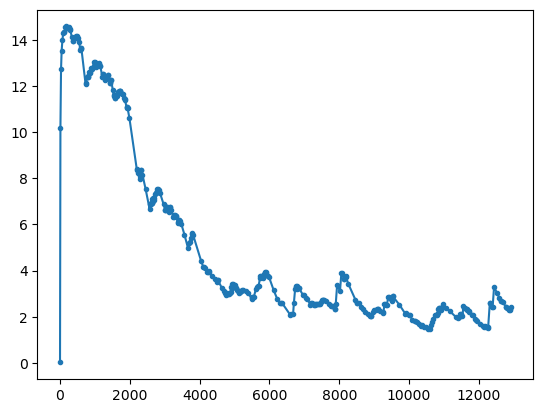

In [607]:
plt.plot(stretched_points[:,0], stretched_points[:,1], '.-')